<a href="https://colab.research.google.com/github/SLTH-Project/ThSL-Model/blob/main/Train/Find_Parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/All Dataset/Github/Dataset_Original_SLTH_100_Resize2.zip'

In [ ]:
%cd '/content'

/content


In [ ]:
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/All Dataset/Github/Dataset_Original_SLTH_100_Resize2.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content')
  print('Done')

Done


#Import

In [ ]:
from numpy import expand_dims
import numpy as np

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


import tensorflow
import tensorflow as tf

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

from PIL import Image 
from PIL import ImageFilter 

from scipy import ndimage
from skimage.transform import resize

import os
from os import listdir

import cv2
import time
import random

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model, load_model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import BatchNormalization

#Split folder

In [ ]:
!pip install split_folders

In [ ]:
pip install split-folders tqdm

In [ ]:
import splitfolders 

## Train : Validation : Test 

In [ ]:
DATA_PATH = '/content/Dataset_Original_SLTH_100_Resize2'

Train set : 70%, Test set : 20%, Validation set : 10%

In [ ]:
SAVE_DATA_PATH = '/content/Dataset_Split_test2/'
os.makedirs(SAVE_DATA_PATH)

In [ ]:
splitfolders.ratio(DATA_PATH, output=SAVE_DATA_PATH, seed=1337, ratio=(0.7, 0.1, 0.2)) # (train:val:test)

Copying files: 12000 files [00:01, 7959.96 files/s]


#Load dataset

In [ ]:
SIZE =224
CLASS_MODE = 'sparse'  #sparse
BATCH_SIZE = 32
NUM_CLASS=100
COLOR_MODE ='rgb'
CHANNEL = 3

In [ ]:
root_dir = '/content/'
dataset_dir = os.path.join(root_dir, 'Dataset_Split_test2')
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

Trian

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input ,dtype='float32') #included in our dependencies
train_generator = train_datagen.flow_from_directory(train_dir, # this is where you specify the path to the main data folder
                                                 target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                 )

Found 8400 images belonging to 100 classes.


Test

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
test_generator = train_datagen.flow_from_directory(test_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=False
                                                 )

Found 2400 images belonging to 100 classes.


In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,dtype='float32') #included in our dependencies
val_generator = val_datagen.flow_from_directory(val_dir, # this is where you specify the path to the main data folder
                                                  target_size=(SIZE, SIZE),
                                                 color_mode=COLOR_MODE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE,
                                                 seed=123,
                                                 shuffle=True
                                                )

Found 1200 images belonging to 100 classes.


#MobileNetV2

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv2_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 57s 204ms/step - loss: 4.6696 - accuracy: 0.0234 - val_loss: 4.0591 - val_accuracy: 0.1014
Epoch 2/120
262/262 [==============================] - 56s 215ms/step - loss: 4.1524 - accuracy: 0.0546 - val_loss: 3.4858 - val_accuracy: 0.1934
Epoch 3/120
262/262 [==============================] - 58s 222ms/step - loss: 3.7441 - accuracy: 0.0888 - val_loss: 3.0692 - val_accuracy: 0.2610
Epoch 4/120
262/262 [==============================] - 56s 213ms/step - loss: 3.4267 - accuracy: 0.1153 - val_loss: 2.7449 - val_accuracy: 0.3682
Epoch 5/120
262/262 [==============================] - 57s 217ms/step - loss: 3.1539 - accuracy: 0.1552 - val_loss: 2.4480 - val_accuracy: 0.4172
Epoch 6/120
262/262 [==============================] - 58s 223ms/step - loss: 2.9533 - accuracy: 0.1836 - val_loss: 2.2353 - val_accuracy: 0.4595
Epoch 7/120
262/262 [==============================] - 55s 211ms/step - loss: 2.8012 - accuracy: 0.2047 - val_loss: 2.0208 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv2_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_2)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 82s 300ms/step - loss: 1.2784 - accuracy: 0.5882 - val_loss: 0.6815 - val_accuracy: 0.7965
Epoch 2/75
262/262 [==============================] - 77s 294ms/step - loss: 1.2532 - accuracy: 0.5962 - val_loss: 0.6722 - val_accuracy: 0.8032
Epoch 3/75
262/262 [==============================] - 72s 276ms/step - loss: 1.2394 - accuracy: 0.6044 - val_loss: 0.6760 - val_accuracy: 0.8007
Epoch 4/75
262/262 [==============================] - 73s 279ms/step - loss: 1.2020 - accuracy: 0.6082 - val_loss: 0.6711 - val_accuracy: 0.8024
Epoch 5/75
262/262 [==============================] - 71s 270ms/step - loss: 1.1852 - accuracy: 0.6096 - val_loss: 0.6689 - val_accuracy: 0.7998
Epoch 6/75
262/262 [==============================] - 75s 286ms/step - loss: 1.2207 - accuracy: 0.6120 - val_loss: 0.6680 - val_accuracy: 0.7998
Epoch 7/75
262/262 [==============================] - 74s 281ms/step - loss: 1.1992 - accuracy: 0.6084 - val_loss: 0.6679 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv2_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_3)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 42s 145ms/step - loss: 1.0558 - accuracy: 0.6538 - val_loss: 0.6096 - val_accuracy: 0.8285
Epoch 2/75
262/262 [==============================] - 39s 148ms/step - loss: 1.0656 - accuracy: 0.6544 - val_loss: 0.6067 - val_accuracy: 0.8252
Epoch 3/75
262/262 [==============================] - 39s 150ms/step - loss: 1.0408 - accuracy: 0.6594 - val_loss: 0.6119 - val_accuracy: 0.8243
Epoch 4/75
262/262 [==============================] - 40s 152ms/step - loss: 1.0333 - accuracy: 0.6580 - val_loss: 0.6049 - val_accuracy: 0.8336
Epoch 5/75
262/262 [==============================] - 39s 151ms/step - loss: 1.0515 - accuracy: 0.6636 - val_loss: 0.6084 - val_accuracy: 0.8260
Epoch 6/75
262/262 [==============================] - 40s 152ms/step - loss: 1.0598 - accuracy: 0.6591 - val_loss: 0.6125 - val_accuracy: 0.8269
Epoch 7/75
262/262 [==============================] - 39s 149ms/step - loss: 1.0418 - accuracy: 0.6618 - val_loss: 0.6083 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6| 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv2_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_4)
model_MBv2_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv2_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 47s 168ms/step - loss: 1.0347 - accuracy: 0.6617 - val_loss: 0.6016 - val_accuracy: 0.8285
Epoch 2/30
262/262 [==============================] - 44s 168ms/step - loss: 1.0343 - accuracy: 0.6642 - val_loss: 0.6063 - val_accuracy: 0.8252
Epoch 3/30
262/262 [==============================] - 45s 171ms/step - loss: 1.0324 - accuracy: 0.6625 - val_loss: 0.6067 - val_accuracy: 0.8269
Epoch 4/30
262/262 [==============================] - 45s 172ms/step - loss: 1.0339 - accuracy: 0.6619 - val_loss: 0.6025 - val_accuracy: 0.8260
Epoch 5/30
262/262 [==============================] - 40s 153ms/step - loss: 1.0469 - accuracy: 0.6588 - val_loss: 0.6056 - val_accuracy: 0.8260
Epoch 6/30
262/262 [==============================] - 41s 157ms/step - loss: 1.0110 - accuracy: 0.6708 - val_loss: 0.6047 - val_accuracy: 0.8226
Epoch 7/30
262/262 [==============================] - 39s 150ms/step - loss: 1.0625 - accuracy: 0.6534 - val_loss: 0.6012 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 12s 148ms/step - loss: 0.5728 - accuracy: 0.8271
test_acc: 0.8270833492279053
test_loss: 0.5728225111961365


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

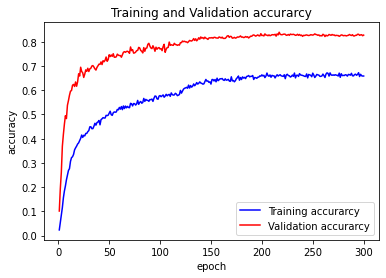

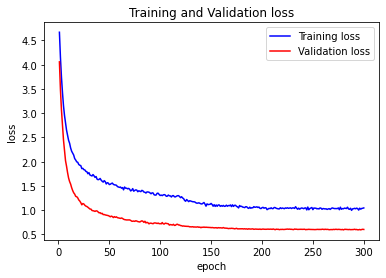

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/model_MBv2.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpk9ci017p/assets


10363972

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.72      0.75      0.73        24
         airplane       1.00      0.92      0.96        24
            angry       0.95      0.79      0.86        24
           animal       0.64      0.58      0.61        24
              bat       0.87      0.83      0.85        24
             bite       1.00      0.92      0.96        24
     bow the head       0.86      1.00      0.92        24
             bowl       0.80      0.67      0.73        24
            bread       0.70      0.79      0.75        24
          buffalo       0.77      0.96      0.85        24
             care       0.96      0.92      0.94        24
              cat       0.88      0.96      0.92        24
            chest       0.83      0.79      0.81        24
           cockle       0.96      0.96      0.96        24
            cough       0.92      0.96      0.94        24
              cow       0.90      0.75      0.82       

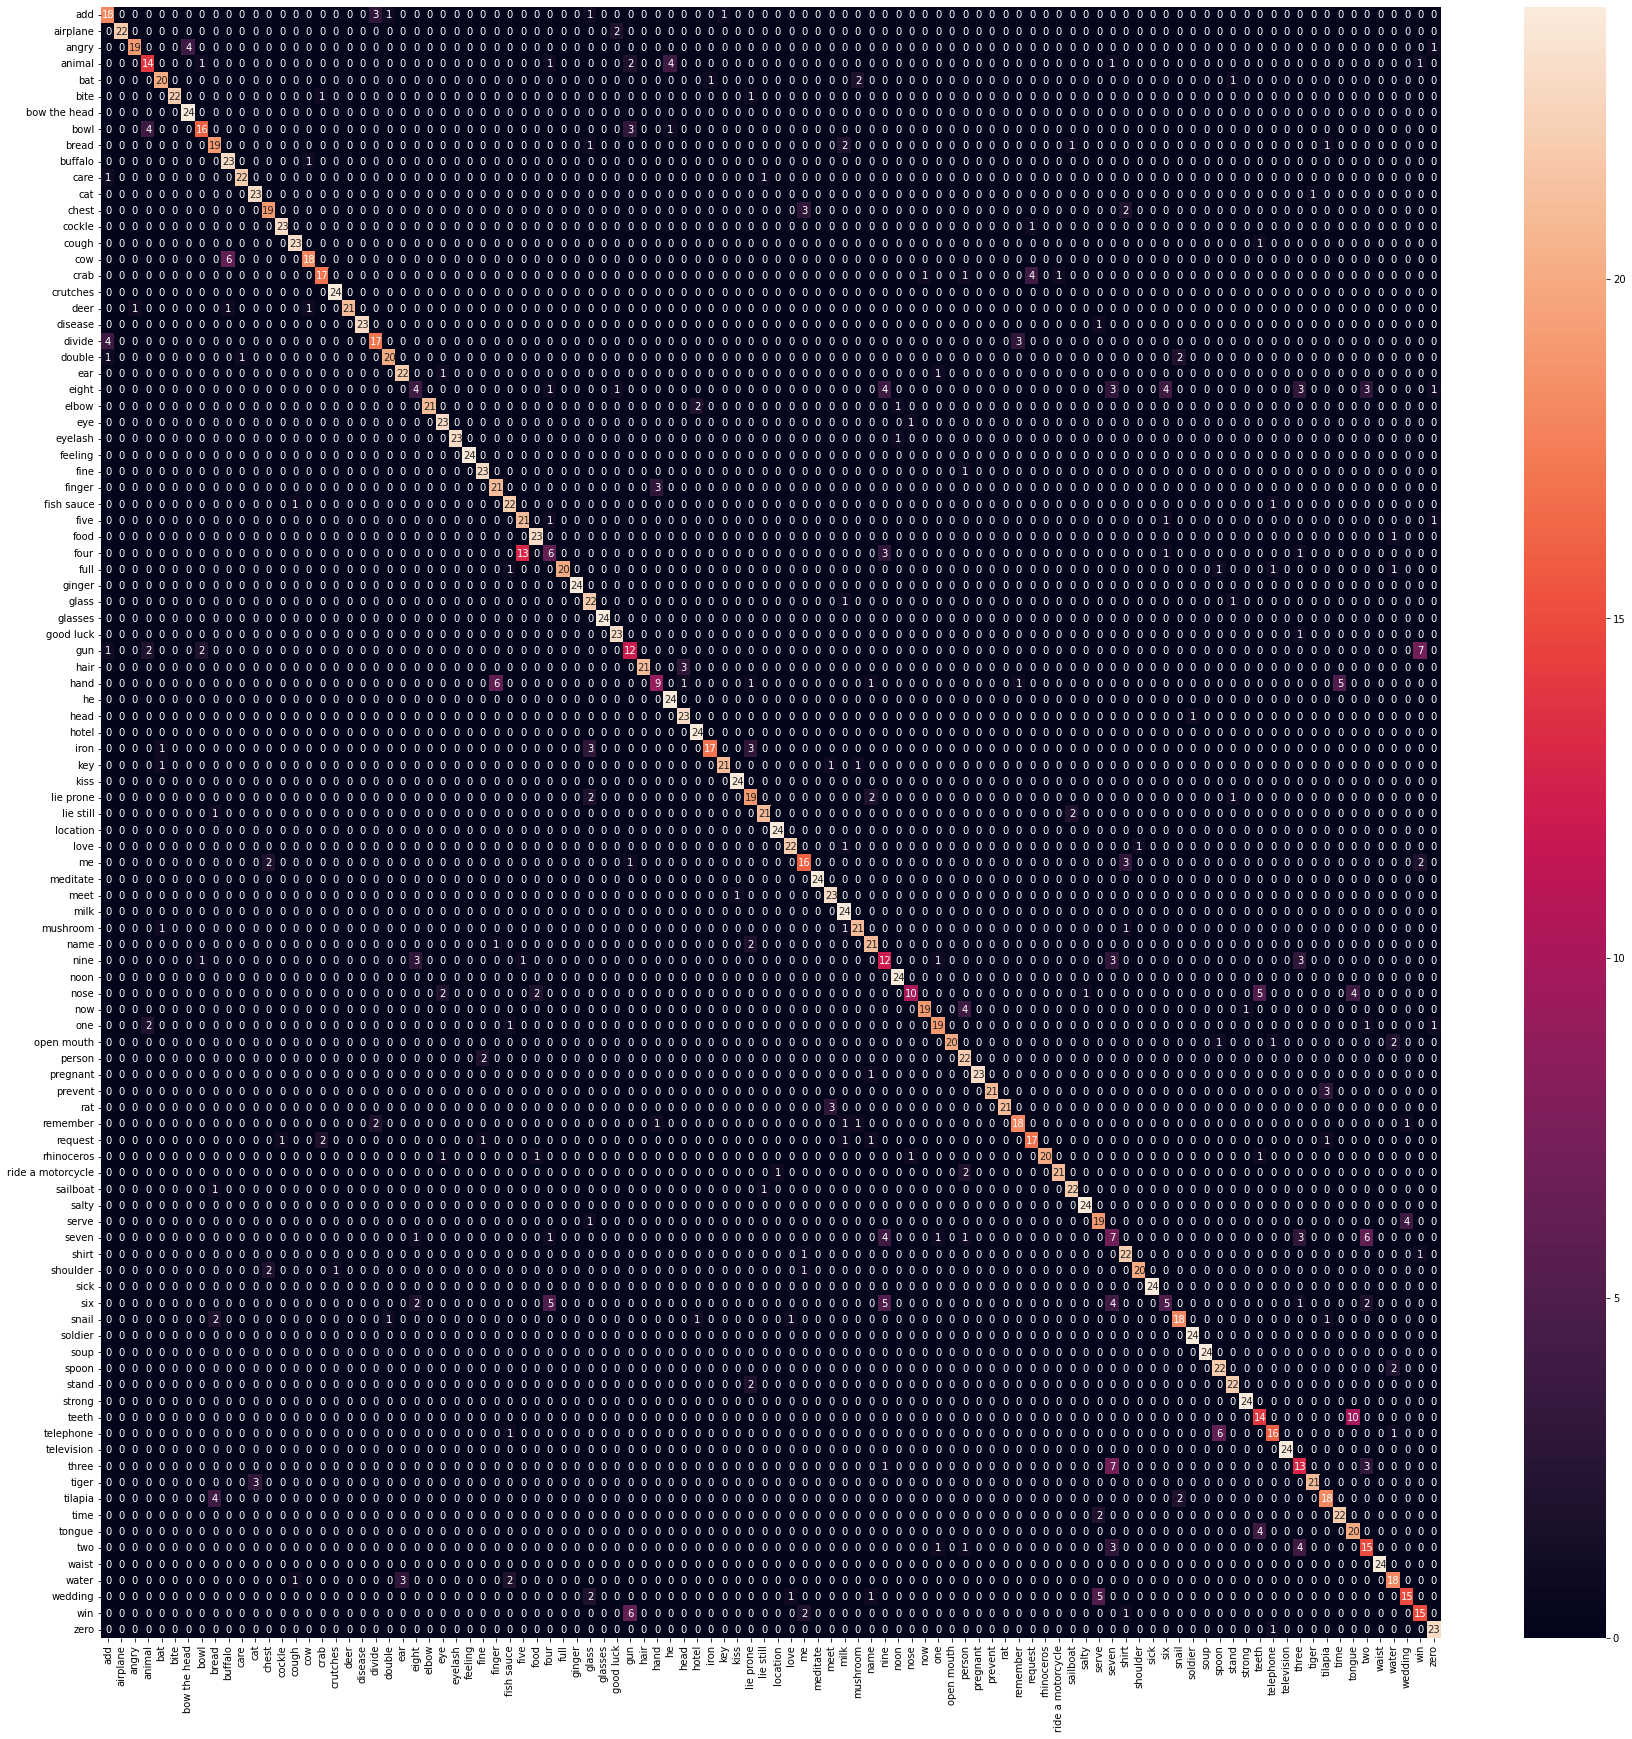

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## rmsProp

In [ ]:
model_MBv2_2= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv2_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 119s 433ms/step - loss: 4.6585 - accuracy: 0.0204 - val_loss: 3.9894 - val_accuracy: 0.1149
Epoch 2/120
262/262 [==============================] - 100s 382ms/step - loss: 4.1132 - accuracy: 0.0647 - val_loss: 3.3878 - val_accuracy: 0.2027
Epoch 3/120
262/262 [==============================] - 101s 386ms/step - loss: 3.7033 - accuracy: 0.1012 - val_loss: 3.0078 - val_accuracy: 0.3133
Epoch 4/120
262/262 [==============================] - 68s 260ms/step - loss: 3.4025 - accuracy: 0.1292 - val_loss: 2.7285 - val_accuracy: 0.3894
Epoch 5/120
262/262 [==============================] - 67s 255ms/step - loss: 3.1693 - accuracy: 0.1622 - val_loss: 2.4716 - val_accuracy: 0.4409
Epoch 6/120
262/262 [==============================] - 72s 276ms/step - loss: 2.9847 - accuracy: 0.1947 - val_loss: 2.2784 - val_accuracy: 0.4730
Epoch 7/120
262/262 [==============================] - 72s 275ms/step - loss: 2.8190 - accuracy: 0.2144 - val_loss: 2.094

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
from keras.models import load_model
model_MBv2_2 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_1.h5')

In [ ]:
SAVE_model_MBv2_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_2)
model_MBv2_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv2_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 91s 331ms/step - loss: 1.4767 - accuracy: 0.5700 - val_loss: 0.6767 - val_accuracy: 0.7829
Epoch 2/75
262/262 [==============================] - 96s 366ms/step - loss: 1.4513 - accuracy: 0.5709 - val_loss: 0.6723 - val_accuracy: 0.7872
Epoch 3/75
262/262 [==============================] - 88s 337ms/step - loss: 1.4446 - accuracy: 0.5792 - val_loss: 0.6684 - val_accuracy: 0.7948
Epoch 4/75
262/262 [==============================] - 87s 334ms/step - loss: 1.3754 - accuracy: 0.5999 - val_loss: 0.6657 - val_accuracy: 0.8049
Epoch 5/75
262/262 [==============================] - 91s 347ms/step - loss: 1.4086 - accuracy: 0.5899 - val_loss: 0.6691 - val_accuracy: 0.7973
Epoch 6/75
262/262 [==============================] - 87s 334ms/step - loss: 1.3975 - accuracy: 0.5966 - val_loss: 0.6675 - val_accuracy: 0.7990
Epoch 7/75
262/262 [==============================] - 91s 348ms/step - loss: 1.4192 - accuracy: 0.5881 - val_loss: 0.6616 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv2_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_3)
model_MBv2_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv2_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
from keras.models import load_model
model_MBv2_2 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_3.h5')

In [ ]:
SAVE_model_MBv2_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_4)
model_MBv2_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv2_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 58s 209ms/step - loss: 1.2362 - accuracy: 0.6426 - val_loss: 0.6191 - val_accuracy: 0.8209
Epoch 2/30
262/262 [==============================] - 58s 223ms/step - loss: 1.2396 - accuracy: 0.6321 - val_loss: 0.6190 - val_accuracy: 0.8184
Epoch 3/30
262/262 [==============================] - 58s 223ms/step - loss: 1.2501 - accuracy: 0.6340 - val_loss: 0.6164 - val_accuracy: 0.8226
Epoch 4/30
262/262 [==============================] - 59s 225ms/step - loss: 1.2526 - accuracy: 0.6347 - val_loss: 0.6188 - val_accuracy: 0.8235
Epoch 5/30
262/262 [==============================] - 57s 218ms/step - loss: 1.2394 - accuracy: 0.6410 - val_loss: 0.6129 - val_accuracy: 0.8252
Epoch 6/30
262/262 [==============================] - 58s 223ms/step - loss: 1.2428 - accuracy: 0.6385 - val_loss: 0.6206 - val_accuracy: 0.8159
Epoch 7/30
262/262 [==============================] - 59s 224ms/step - loss: 1.2326 - accuracy: 0.6362 - val_loss: 0.6116 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 16s 201ms/step - loss: 0.6015 - accuracy: 0.8283
test_acc: 0.82833331823349
test_loss: 0.6015413403511047


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

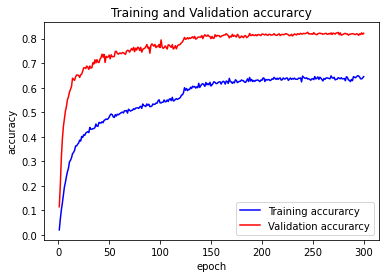

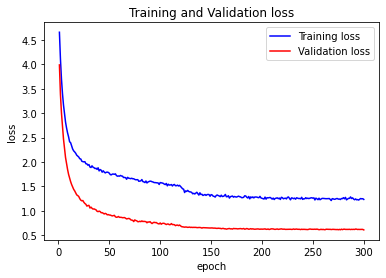

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/model_MBv2.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpghp44g0l/assets


INFO:tensorflow:Assets written to: /tmp/tmpghp44g0l/assets


10363024

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.82      0.75      0.78        24
         airplane       0.96      0.92      0.94        24
            angry       0.88      0.96      0.92        24
           animal       0.75      0.75      0.75        24
              bat       0.85      0.92      0.88        24
             bite       1.00      0.96      0.98        24
     bow the head       0.96      0.96      0.96        24
             bowl       0.89      0.67      0.76        24
            bread       0.71      0.71      0.71        24
          buffalo       0.88      0.96      0.92        24
             care       0.96      0.96      0.96        24
              cat       0.88      0.88      0.88        24
            chest       0.78      0.75      0.77        24
           cockle       0.95      0.83      0.89        24
            cough       0.96      0.96      0.96        24
              cow       0.91      0.88      0.89       

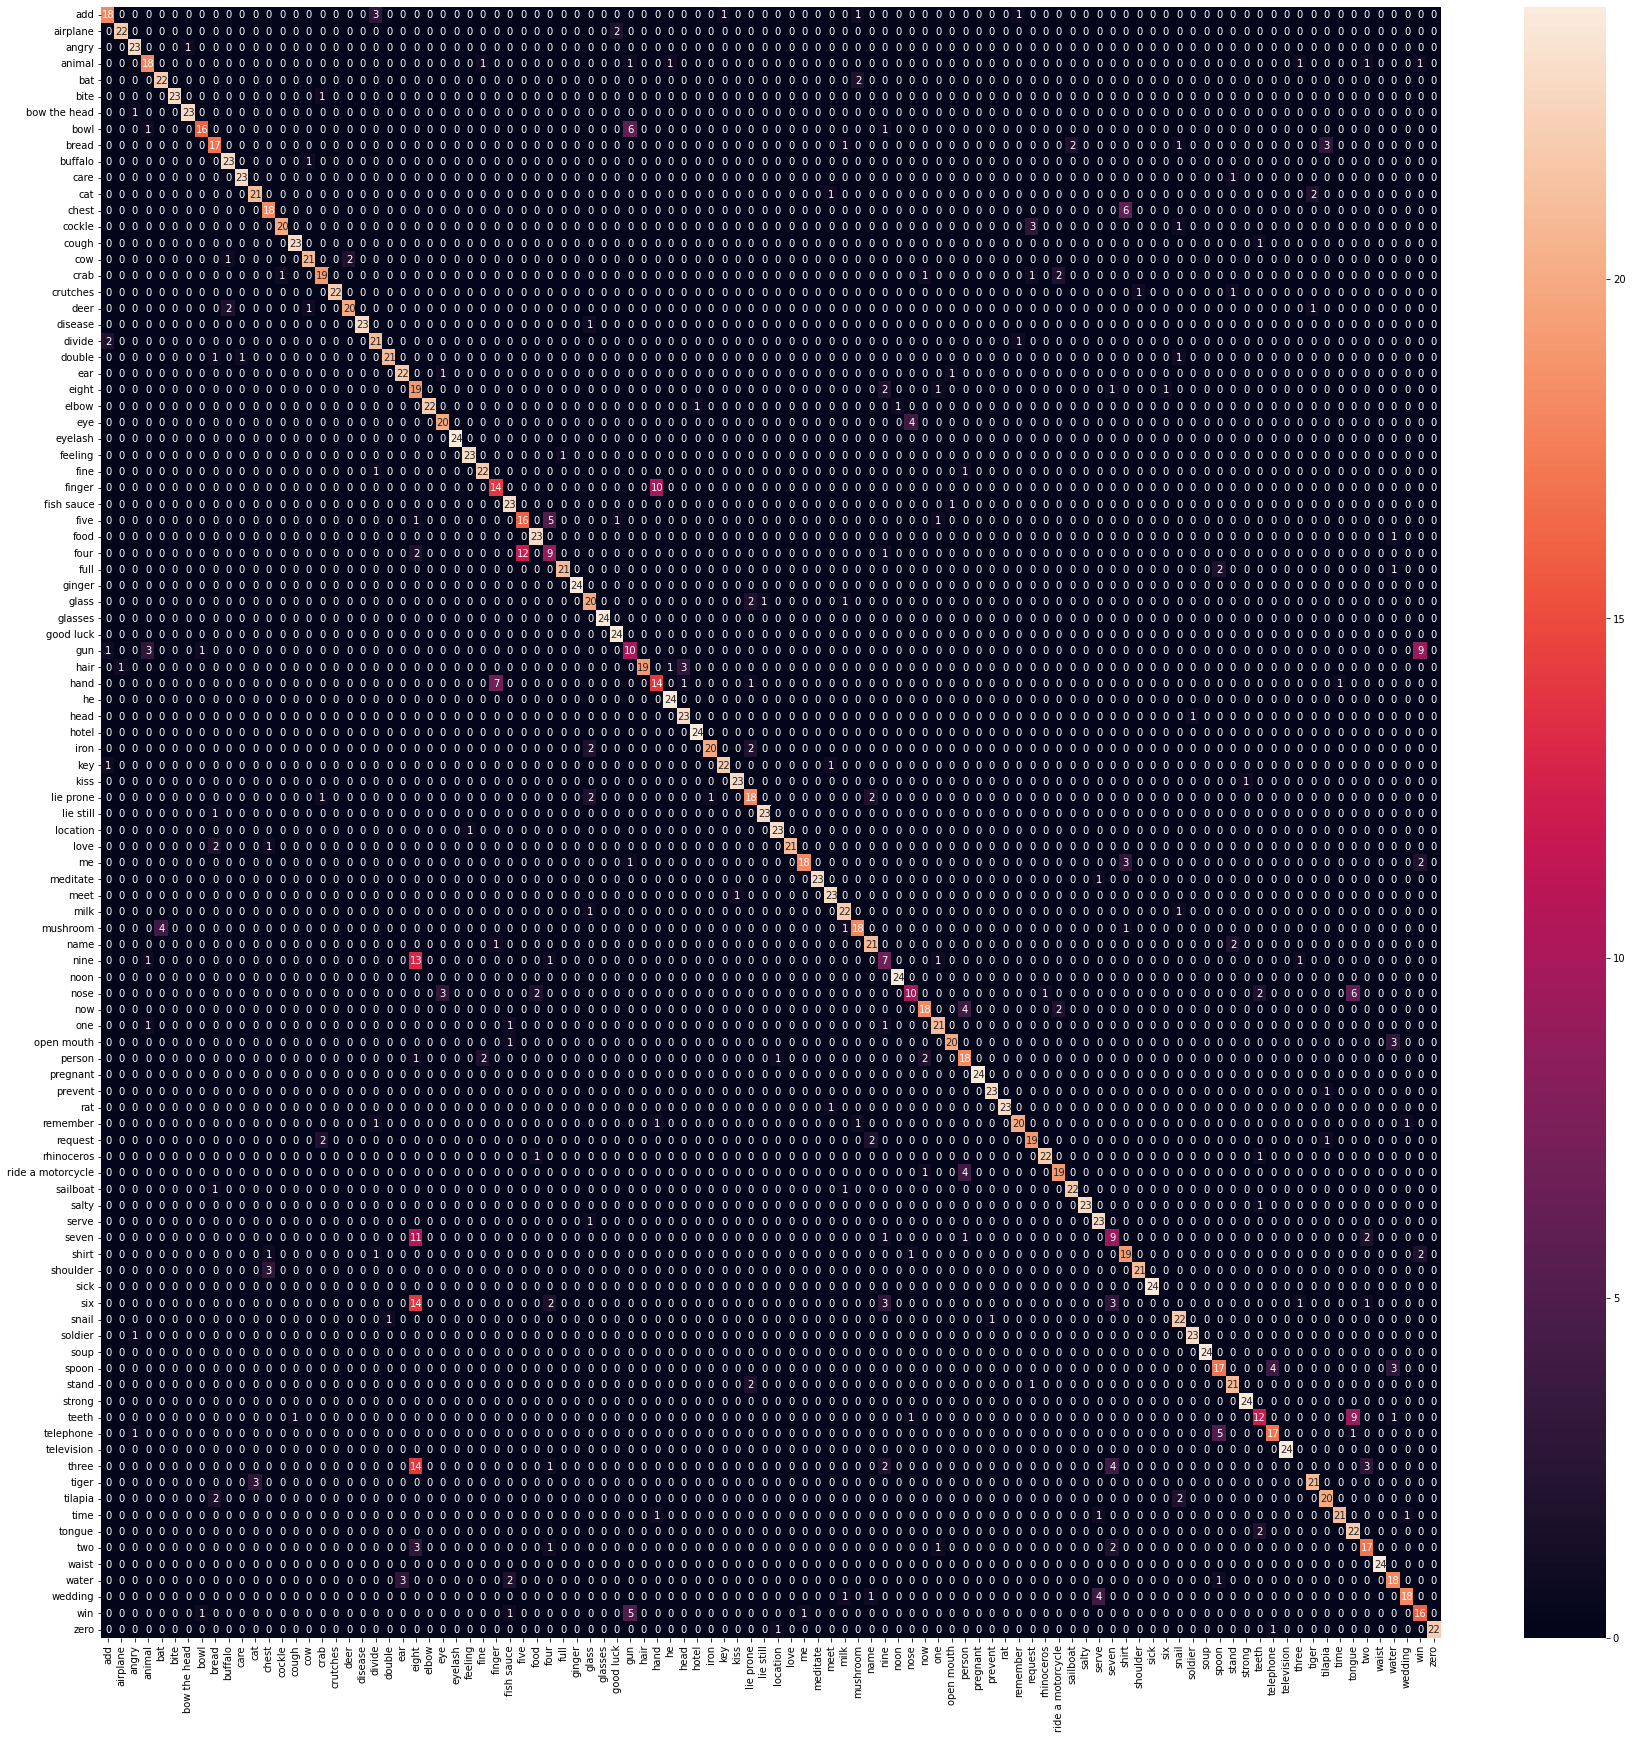

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## SGD

In [ ]:
model_MBv2_3= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv2_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_1)
model_MBv2_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv2_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 82s 302ms/step - loss: 4.9785 - accuracy: 0.0093 - val_loss: 4.6330 - val_accuracy: 0.0135
Epoch 2/120
262/262 [==============================] - 76s 290ms/step - loss: 4.9542 - accuracy: 0.0092 - val_loss: 4.6283 - val_accuracy: 0.0144
Epoch 3/120
262/262 [==============================] - 75s 284ms/step - loss: 4.9539 - accuracy: 0.0102 - val_loss: 4.6174 - val_accuracy: 0.0169
Epoch 4/120
262/262 [==============================] - 66s 251ms/step - loss: 4.9393 - accuracy: 0.0120 - val_loss: 4.6030 - val_accuracy: 0.0169
Epoch 5/120
262/262 [==============================] - 51s 195ms/step - loss: 4.9398 - accuracy: 0.0121 - val_loss: 4.5912 - val_accuracy: 0.0211
Epoch 6/120
262/262 [==============================] - 70s 269ms/step - loss: 4.9053 - accuracy: 0.0110 - val_loss: 4.5807 - val_accuracy: 0.0211
Epoch 7/120
262/262 [==============================] - 95s 361ms/step - loss: 4.8987 - accuracy: 0.0128 - val_loss: 4.5715 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv2_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_2)
model_MBv2_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv2_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 87s 321ms/step - loss: 3.8681 - accuracy: 0.0859 - val_loss: 3.4729 - val_accuracy: 0.2179
Epoch 2/75
262/262 [==============================] - 81s 307ms/step - loss: 3.8661 - accuracy: 0.0889 - val_loss: 3.4760 - val_accuracy: 0.2238
Epoch 3/75
262/262 [==============================] - 82s 314ms/step - loss: 3.8470 - accuracy: 0.0954 - val_loss: 3.4863 - val_accuracy: 0.2204
Epoch 4/75
262/262 [==============================] - 84s 319ms/step - loss: 3.8541 - accuracy: 0.0891 - val_loss: 3.4878 - val_accuracy: 0.2204
Epoch 5/75
262/262 [==============================] - 78s 297ms/step - loss: 3.8571 - accuracy: 0.0896 - val_loss: 3.4837 - val_accuracy: 0.2196
Epoch 6/75
262/262 [==============================] - 77s 292ms/step - loss: 3.8736 - accuracy: 0.0919 - val_loss: 3.4752 - val_accuracy: 0.2238
Epoch 7/75
262/262 [==============================] - 78s 298ms/step - loss: 3.8511 - accuracy: 0.0951 - val_loss: 3.4710 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
from keras.models import load_model
model_MBv2_3 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_2.h5')

In [ ]:
SAVE_model_MBv2_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_3)
model_MBv2_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv2_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 51s 182ms/step - loss: 3.7936 - accuracy: 0.0994 - val_loss: 3.4186 - val_accuracy: 0.2399
Epoch 2/75
262/262 [==============================] - 50s 191ms/step - loss: 3.7992 - accuracy: 0.0969 - val_loss: 3.4147 - val_accuracy: 0.2424
Epoch 3/75
262/262 [==============================] - 45s 170ms/step - loss: 3.8106 - accuracy: 0.0944 - val_loss: 3.4076 - val_accuracy: 0.2356
Epoch 4/75
262/262 [==============================] - 46s 177ms/step - loss: 3.8012 - accuracy: 0.0984 - val_loss: 3.4118 - val_accuracy: 0.2340
Epoch 5/75
262/262 [==============================] - 58s 222ms/step - loss: 3.8071 - accuracy: 0.0956 - val_loss: 3.4125 - val_accuracy: 0.2348
Epoch 6/75
262/262 [==============================] - 52s 197ms/step - loss: 3.8004 - accuracy: 0.0927 - val_loss: 3.4149 - val_accuracy: 0.2348
Epoch 7/75
262/262 [==============================] - 46s 176ms/step - loss: 3.8039 - accuracy: 0.0945 - val_loss: 3.4015 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv2_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv2_4)
model_MBv2_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv2_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 53s 191ms/step - loss: 3.8104 - accuracy: 0.0942 - val_loss: 3.4034 - val_accuracy: 0.2449
Epoch 2/30
262/262 [==============================] - 52s 199ms/step - loss: 3.8053 - accuracy: 0.0956 - val_loss: 3.4152 - val_accuracy: 0.2407
Epoch 3/30
262/262 [==============================] - 56s 212ms/step - loss: 3.8018 - accuracy: 0.0930 - val_loss: 3.4154 - val_accuracy: 0.2407
Epoch 4/30
262/262 [==============================] - 54s 206ms/step - loss: 3.7974 - accuracy: 0.0973 - val_loss: 3.4106 - val_accuracy: 0.2399
Epoch 5/30
262/262 [==============================] - 56s 214ms/step - loss: 3.7935 - accuracy: 0.0960 - val_loss: 3.4000 - val_accuracy: 0.2399
Epoch 6/30
262/262 [==============================] - 59s 223ms/step - loss: 3.7976 - accuracy: 0.1004 - val_loss: 3.4080 - val_accuracy: 0.2382
Epoch 7/30
262/262 [==============================] - 52s 200ms/step - loss: 3.8150 - accuracy: 0.0890 - val_loss: 3.3999 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 21s 266ms/step - loss: 3.4071 - accuracy: 0.2308
test_acc: 0.23083333671092987
test_loss: 3.4071435928344727


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

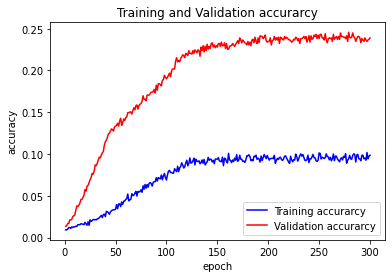

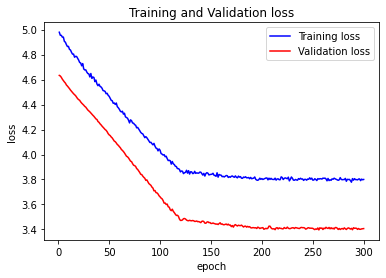

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/model_MBv2.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpzhvg4zf5/assets


INFO:tensorflow:Assets written to: /tmp/tmpzhvg4zf5/assets


10363908

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.00      0.00      0.00        24
         airplane       0.50      0.04      0.08        24
            angry       0.33      0.21      0.26        24
           animal       0.20      0.04      0.07        24
              bat       0.26      0.29      0.27        24
             bite       0.37      0.54      0.44        24
     bow the head       1.00      0.04      0.08        24
             bowl       0.00      0.00      0.00        24
            bread       0.50      0.04      0.08        24
          buffalo       0.42      0.58      0.49        24
             care       0.38      0.67      0.48        24
              cat       0.69      0.46      0.55        24
            chest       0.10      0.58      0.16        24
           cockle       0.67      0.17      0.27        24
            cough       0.12      0.08      0.10        24
              cow       0.45      0.75      0.56       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


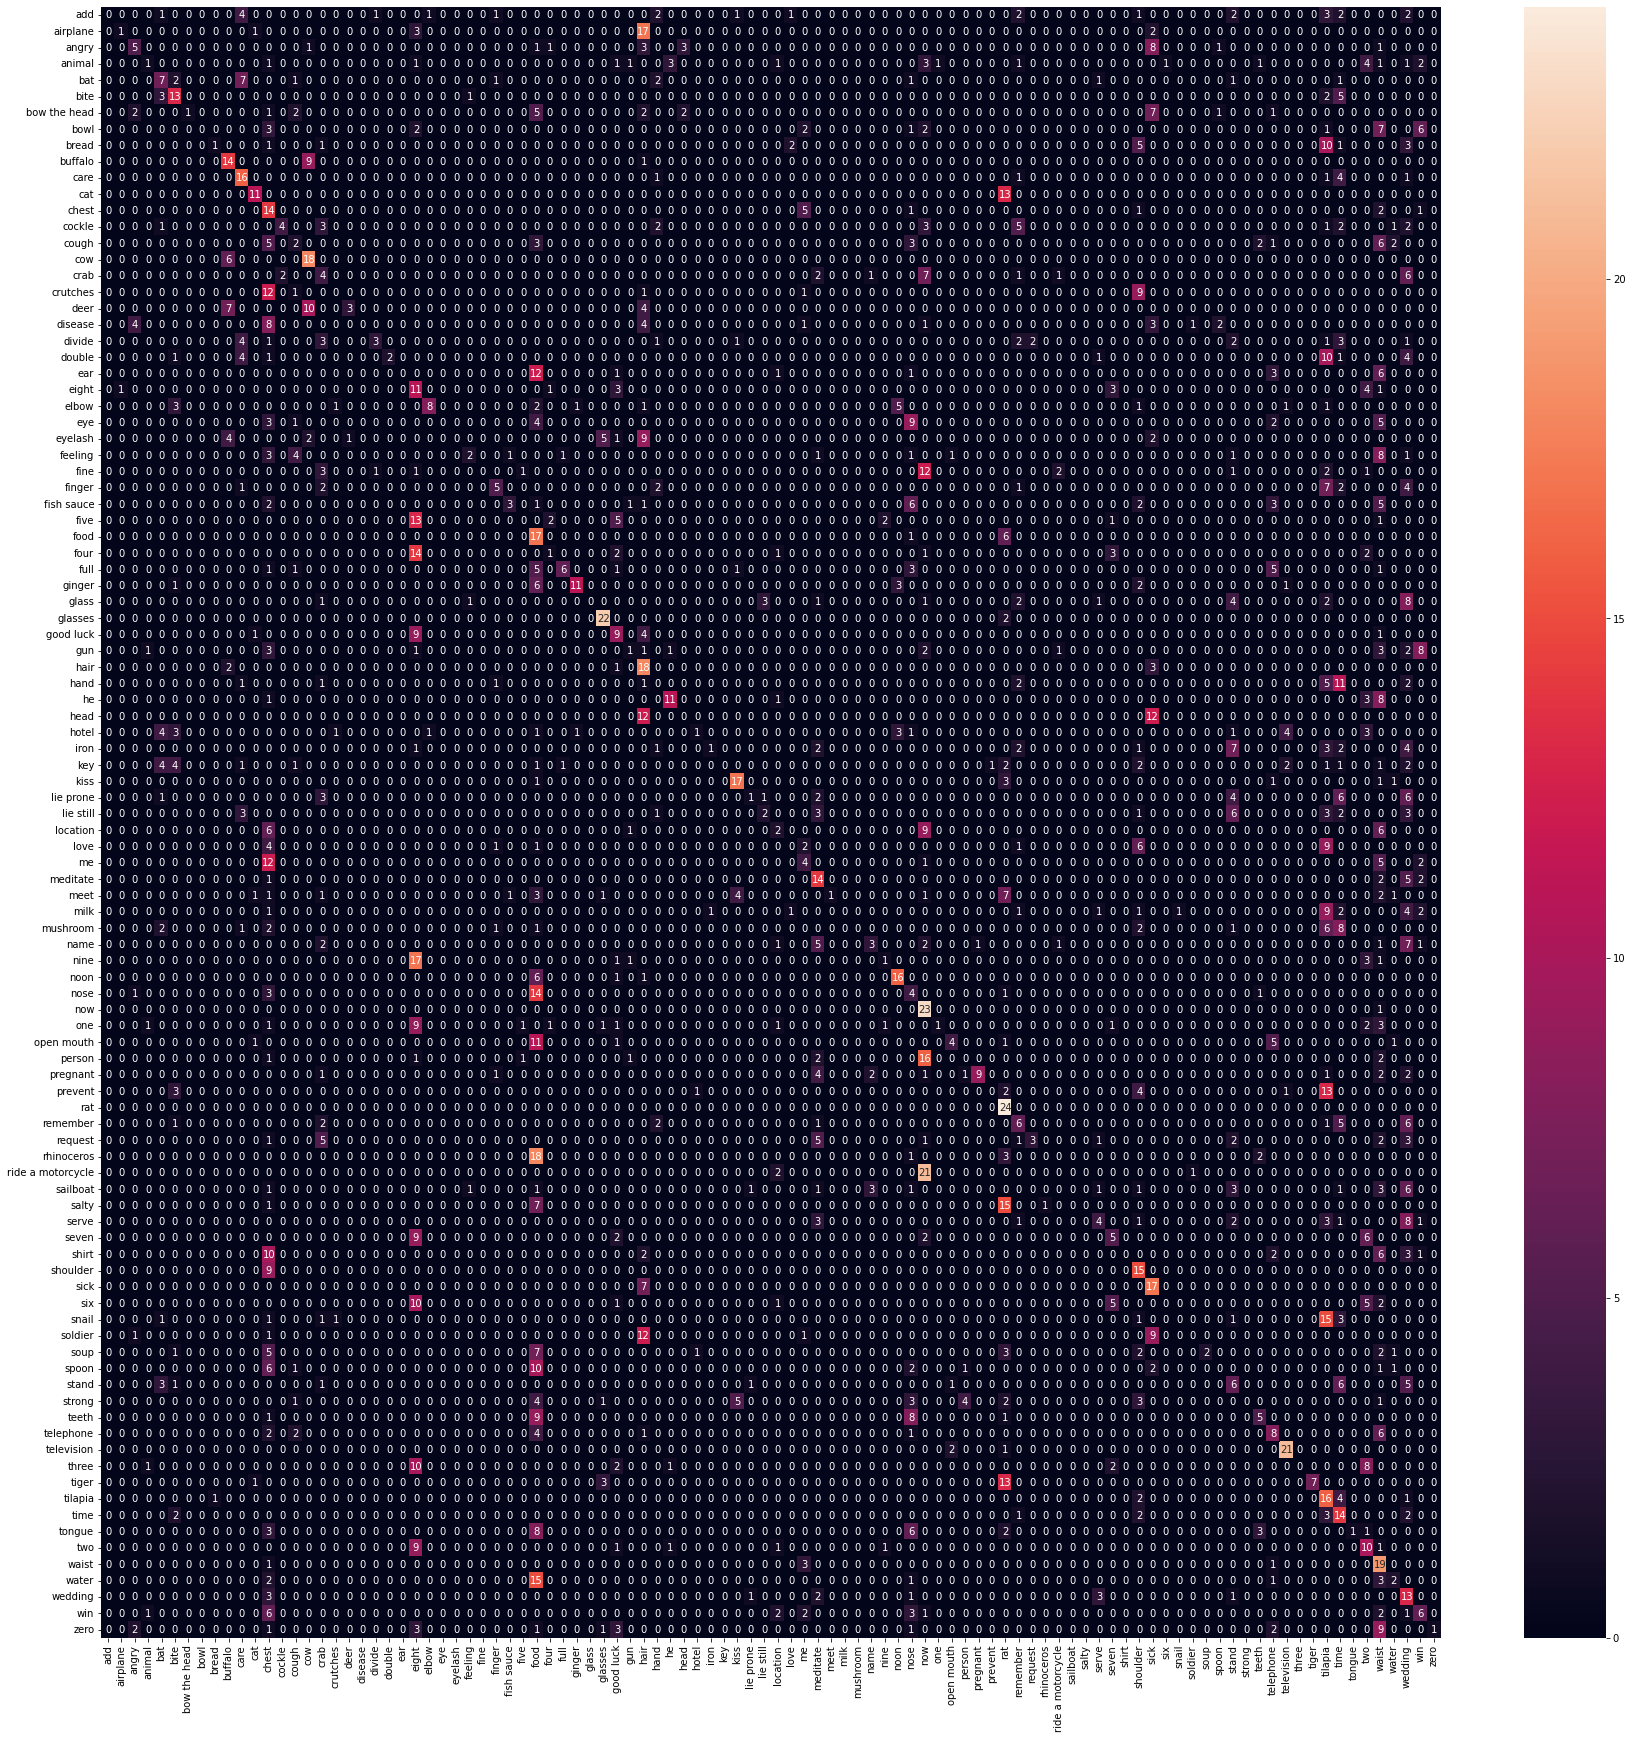

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

##Recap graph MobileNetV2

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

Path_Adam = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/Adam/history.csv'
with open(Path_Adam, 'rb') as handle:
    his_Adam = load(handle)

Path_rmsProp = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/rmsProp/history.csv'
with open(Path_rmsProp , 'rb') as handle:
    his_rmsProp = load(handle)

Path_SGD = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/SGD/history.csv'
with open(Path_SGD, 'rb') as handle:
    his_SGD = load(handle)



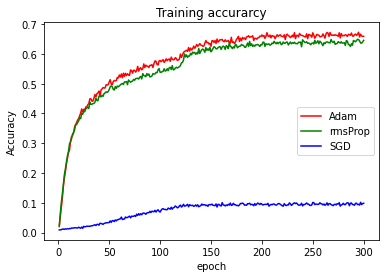

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Accuracy
acc1 = his_Adam['accuracy']
acc2 = his_rmsProp['accuracy']
acc3 = his_SGD['accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training accurarcy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()


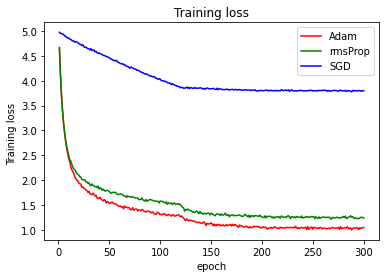

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Loss
acc1 = his_Adam['loss']
acc2 = his_rmsProp['loss']
acc3 = his_SGD['loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training loss')
plt.ylabel('Training loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

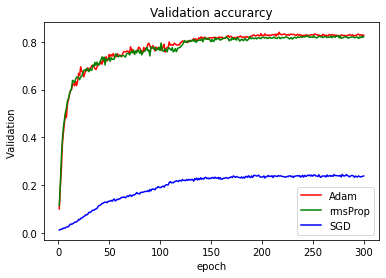

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Accuracy
acc1 = his_Adam['val_accuracy']
acc2 = his_rmsProp['val_accuracy']
acc3 = his_SGD['val_accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation accurarcy')
plt.ylabel('Validation ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

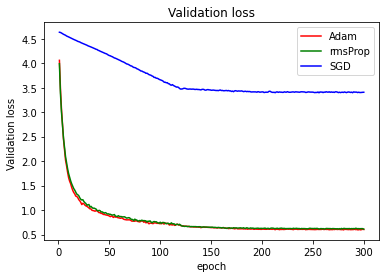

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Loss
acc1 = his_Adam['val_loss']
acc2 = his_rmsProp['val_loss']
acc3 = his_SGD['val_loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation loss')
plt.ylabel('Validation loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

#MobileNetV3Large

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv3L_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3L_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_1)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 56s 197ms/step - loss: 4.8401 - accuracy: 0.0128 - val_loss: 4.5454 - val_accuracy: 0.0329
Epoch 2/120
262/262 [==============================] - 55s 210ms/step - loss: 4.6037 - accuracy: 0.0235 - val_loss: 4.3516 - val_accuracy: 0.0709
Epoch 3/120
262/262 [==============================] - 55s 211ms/step - loss: 4.4227 - accuracy: 0.0326 - val_loss: 4.1144 - val_accuracy: 0.0929
Epoch 4/120
262/262 [==============================] - 55s 210ms/step - loss: 4.2108 - accuracy: 0.0458 - val_loss: 3.8816 - val_accuracy: 0.1132
Epoch 5/120
262/262 [==============================] - 56s 212ms/step - loss: 4.0030 - accuracy: 0.0590 - val_loss: 3.6681 - val_accuracy: 0.1326
Epoch 6/120
262/262 [==============================] - 57s 217ms/step - loss: 3.8576 - accuracy: 0.0668 - val_loss: 3.4651 - val_accuracy: 0.1562
Epoch 7/120
262/262 [==============================] - 59s 225ms/step - loss: 3.7126 - accuracy: 0.0811 - val_loss: 3.3081 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3L_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_2)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 68s 243ms/step - loss: 2.0900 - accuracy: 0.3560 - val_loss: 1.5868 - val_accuracy: 0.5304
Epoch 2/75
262/262 [==============================] - 71s 273ms/step - loss: 2.1056 - accuracy: 0.3497 - val_loss: 1.5808 - val_accuracy: 0.5397
Epoch 3/75
262/262 [==============================] - 71s 272ms/step - loss: 2.0671 - accuracy: 0.3610 - val_loss: 1.5797 - val_accuracy: 0.5397
Epoch 4/75
262/262 [==============================] - 69s 265ms/step - loss: 2.0736 - accuracy: 0.3616 - val_loss: 1.5736 - val_accuracy: 0.5431
Epoch 5/75
262/262 [==============================] - 73s 280ms/step - loss: 2.0563 - accuracy: 0.3638 - val_loss: 1.5596 - val_accuracy: 0.5490
Epoch 6/75
262/262 [==============================] - 74s 284ms/step - loss: 2.0501 - accuracy: 0.3626 - val_loss: 1.5573 - val_accuracy: 0.5524
Epoch 7/75
262/262 [==============================] - 72s 275ms/step - loss: 2.0473 - accuracy: 0.3699 - val_loss: 1.5616 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3L_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_3)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 81s 291ms/step - loss: 1.8435 - accuracy: 0.4146 - val_loss: 1.4480 - val_accuracy: 0.5802
Epoch 2/75
262/262 [==============================] - 76s 290ms/step - loss: 1.8750 - accuracy: 0.4156 - val_loss: 1.4436 - val_accuracy: 0.5785
Epoch 3/75
262/262 [==============================] - 81s 308ms/step - loss: 1.8452 - accuracy: 0.4247 - val_loss: 1.4402 - val_accuracy: 0.5828
Epoch 4/75
262/262 [==============================] - 78s 298ms/step - loss: 1.8508 - accuracy: 0.4185 - val_loss: 1.4512 - val_accuracy: 0.5760
Epoch 5/75
262/262 [==============================] - 82s 312ms/step - loss: 1.8589 - accuracy: 0.4069 - val_loss: 1.4382 - val_accuracy: 0.5777
Epoch 6/75
262/262 [==============================] - 78s 296ms/step - loss: 1.8601 - accuracy: 0.4099 - val_loss: 1.4434 - val_accuracy: 0.5785
Epoch 7/75
262/262 [==============================] - 83s 315ms/step - loss: 1.8739 - accuracy: 0.4083 - val_loss: 1.4386 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6| 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3L_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_4)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 100s 365ms/step - loss: 1.8298 - accuracy: 0.4223 - val_loss: 1.4388 - val_accuracy: 0.5777
Epoch 2/30
262/262 [==============================] - 80s 305ms/step - loss: 1.8320 - accuracy: 0.4218 - val_loss: 1.4359 - val_accuracy: 0.5802
Epoch 3/30
262/262 [==============================] - 80s 305ms/step - loss: 1.8548 - accuracy: 0.4183 - val_loss: 1.4404 - val_accuracy: 0.5802
Epoch 4/30
262/262 [==============================] - 74s 282ms/step - loss: 1.8409 - accuracy: 0.4163 - val_loss: 1.4420 - val_accuracy: 0.5726
Epoch 5/30
262/262 [==============================] - 75s 288ms/step - loss: 1.8593 - accuracy: 0.4184 - val_loss: 1.4385 - val_accuracy: 0.5769
Epoch 6/30
262/262 [==============================] - 74s 281ms/step - loss: 1.8601 - accuracy: 0.4217 - val_loss: 1.4260 - val_accuracy: 0.5811
Epoch 7/30
262/262 [==============================] - 75s 284ms/step - loss: 1.8533 - accuracy: 0.4172 - val_loss: 1.4329 - val_a

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 26s 337ms/step - loss: 1.3727 - accuracy: 0.5962
test_acc: 0.5962499976158142
test_loss: 1.3727052211761475


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

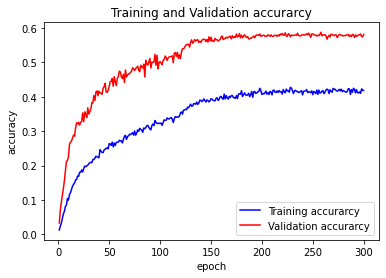

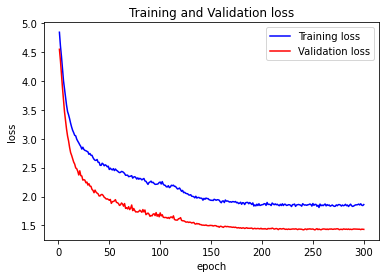

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/model_MBv3L.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp5erw8dwf/assets


13070840

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.50      0.50      0.50        24
         airplane       0.85      0.92      0.88        24
            angry       0.71      0.83      0.77        24
           animal       0.38      0.33      0.36        24
              bat       0.72      0.75      0.73        24
             bite       0.46      0.67      0.54        24
     bow the head       0.91      0.88      0.89        24
             bowl       0.38      0.38      0.38        24
            bread       0.56      0.21      0.30        24
          buffalo       0.83      0.83      0.83        24
             care       0.67      0.83      0.74        24
              cat       0.57      0.71      0.63        24
            chest       0.65      0.71      0.68        24
           cockle       0.42      0.46      0.44        24
            cough       0.60      0.88      0.71        24
              cow       0.71      0.62      0.67       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


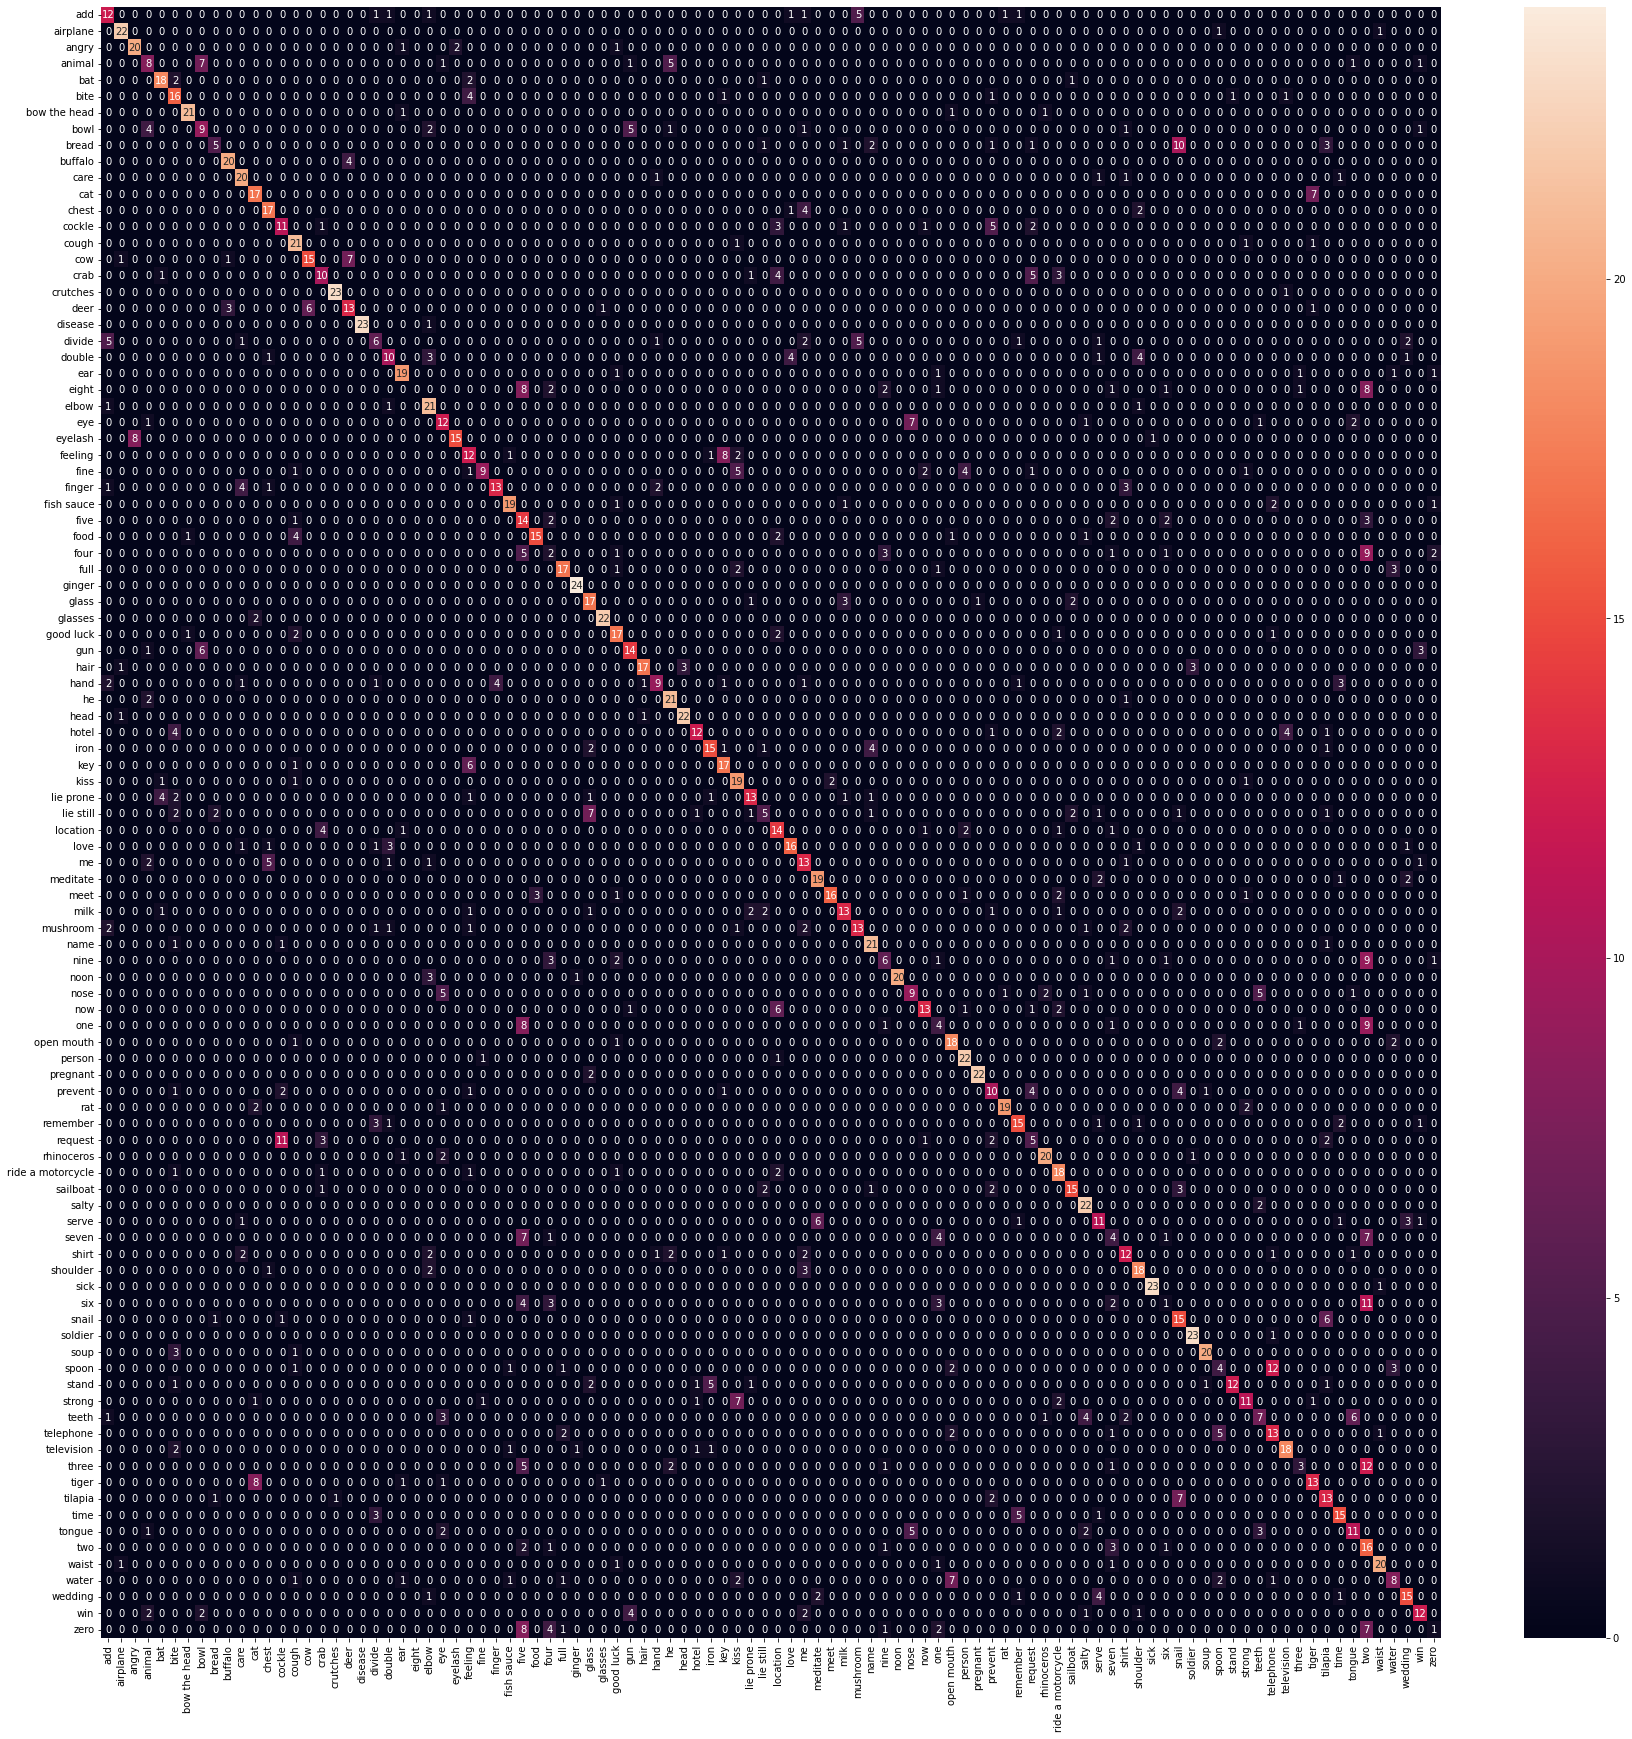

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## rmsProp

In [ ]:
model_MBv3L_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3L_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_1)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 59s 207ms/step - loss: 4.7927 - accuracy: 0.0158 - val_loss: 4.5548 - val_accuracy: 0.0203
Epoch 2/120
262/262 [==============================] - 58s 223ms/step - loss: 4.5802 - accuracy: 0.0222 - val_loss: 4.3706 - val_accuracy: 0.0600
Epoch 3/120
262/262 [==============================] - 60s 229ms/step - loss: 4.3984 - accuracy: 0.0342 - val_loss: 4.0976 - val_accuracy: 0.0963
Epoch 4/120
262/262 [==============================] - 64s 245ms/step - loss: 4.1955 - accuracy: 0.0451 - val_loss: 3.8655 - val_accuracy: 0.1242
Epoch 5/120
262/262 [==============================] - 62s 237ms/step - loss: 3.9917 - accuracy: 0.0642 - val_loss: 3.6713 - val_accuracy: 0.1301
Epoch 6/120
262/262 [==============================] - 63s 239ms/step - loss: 3.8239 - accuracy: 0.0745 - val_loss: 3.4601 - val_accuracy: 0.1807
Epoch 7/120
262/262 [==============================] - 62s 235ms/step - loss: 3.6978 - accuracy: 0.0878 - val_loss: 3.2771 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3L_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_2)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 73s 260ms/step - loss: 2.5254 - accuracy: 0.2866 - val_loss: 1.8186 - val_accuracy: 0.4704
Epoch 2/75
262/262 [==============================] - 75s 285ms/step - loss: 2.5178 - accuracy: 0.2857 - val_loss: 1.8170 - val_accuracy: 0.4890
Epoch 3/75
262/262 [==============================] - 72s 273ms/step - loss: 2.4928 - accuracy: 0.2933 - val_loss: 1.8089 - val_accuracy: 0.4747
Epoch 4/75
262/262 [==============================] - 74s 281ms/step - loss: 2.5141 - accuracy: 0.2902 - val_loss: 1.8087 - val_accuracy: 0.4932
Epoch 5/75
262/262 [==============================] - 76s 289ms/step - loss: 2.4794 - accuracy: 0.2927 - val_loss: 1.7964 - val_accuracy: 0.4907
Epoch 6/75
262/262 [==============================] - 76s 290ms/step - loss: 2.4824 - accuracy: 0.2946 - val_loss: 1.7964 - val_accuracy: 0.4823
Epoch 7/75
262/262 [==============================] - 75s 287ms/step - loss: 2.4704 - accuracy: 0.2942 - val_loss: 1.7984 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3L_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_3)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 74s 264ms/step - loss: 2.3173 - accuracy: 0.3360 - val_loss: 1.7061 - val_accuracy: 0.5169
Epoch 2/75
262/262 [==============================] - 62s 236ms/step - loss: 2.3077 - accuracy: 0.3344 - val_loss: 1.7046 - val_accuracy: 0.5169
Epoch 3/75
262/262 [==============================] - 70s 268ms/step - loss: 2.3310 - accuracy: 0.3360 - val_loss: 1.6947 - val_accuracy: 0.5296
Epoch 4/75
262/262 [==============================] - 71s 271ms/step - loss: 2.2881 - accuracy: 0.3364 - val_loss: 1.7017 - val_accuracy: 0.5220
Epoch 5/75
262/262 [==============================] - 72s 275ms/step - loss: 2.3318 - accuracy: 0.3341 - val_loss: 1.6981 - val_accuracy: 0.5177
Epoch 6/75
262/262 [==============================] - 69s 263ms/step - loss: 2.2896 - accuracy: 0.3369 - val_loss: 1.7045 - val_accuracy: 0.5329
Epoch 7/75
262/262 [==============================] - 69s 263ms/step - loss: 2.3103 - accuracy: 0.3472 - val_loss: 1.7056 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3L_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_4)
model_MBv3L_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3L_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 98s 353ms/step - loss: 2.2980 - accuracy: 0.3436 - val_loss: 1.7073 - val_accuracy: 0.5236
Epoch 2/30
262/262 [==============================] - 87s 331ms/step - loss: 2.3107 - accuracy: 0.3334 - val_loss: 1.7039 - val_accuracy: 0.5211
Epoch 3/30
262/262 [==============================] - 82s 313ms/step - loss: 2.3036 - accuracy: 0.3371 - val_loss: 1.7058 - val_accuracy: 0.5203
Epoch 4/30
262/262 [==============================] - 79s 301ms/step - loss: 2.2960 - accuracy: 0.3386 - val_loss: 1.6944 - val_accuracy: 0.5211
Epoch 5/30
262/262 [==============================] - 80s 306ms/step - loss: 2.3136 - accuracy: 0.3308 - val_loss: 1.6973 - val_accuracy: 0.5177
Epoch 6/30
262/262 [==============================] - 80s 305ms/step - loss: 2.3263 - accuracy: 0.3440 - val_loss: 1.6982 - val_accuracy: 0.5287
Epoch 7/30
262/262 [==============================] - 80s 305ms/step - loss: 2.3055 - accuracy: 0.3378 - val_loss: 1.7001 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 21s 264ms/step - loss: 1.6782 - accuracy: 0.5446
test_acc: 0.5445833206176758
test_loss: 1.6781916618347168


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

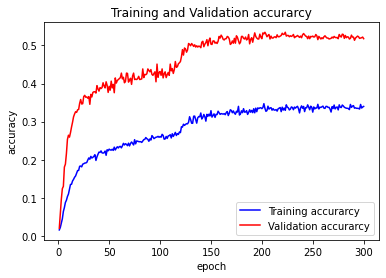

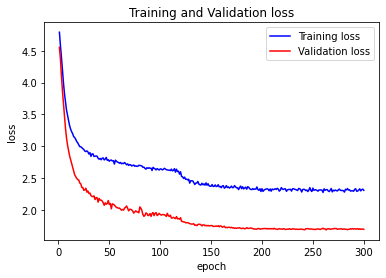

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/model_MBv3L.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmps4_dw_4p/assets


13069124

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.33      0.38      0.35        24
         airplane       0.85      0.92      0.88        24
            angry       0.78      0.75      0.77        24
           animal       0.42      0.46      0.44        24
              bat       0.62      0.75      0.68        24
             bite       0.57      0.67      0.62        24
     bow the head       0.75      0.88      0.81        24
             bowl       0.40      0.50      0.44        24
            bread       0.50      0.04      0.08        24
          buffalo       0.75      0.75      0.75        24
             care       0.70      0.67      0.68        24
              cat       0.52      0.54      0.53        24
            chest       0.42      0.46      0.44        24
           cockle       0.33      0.46      0.39        24
            cough       0.45      0.71      0.55        24
              cow       0.80      0.67      0.73       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


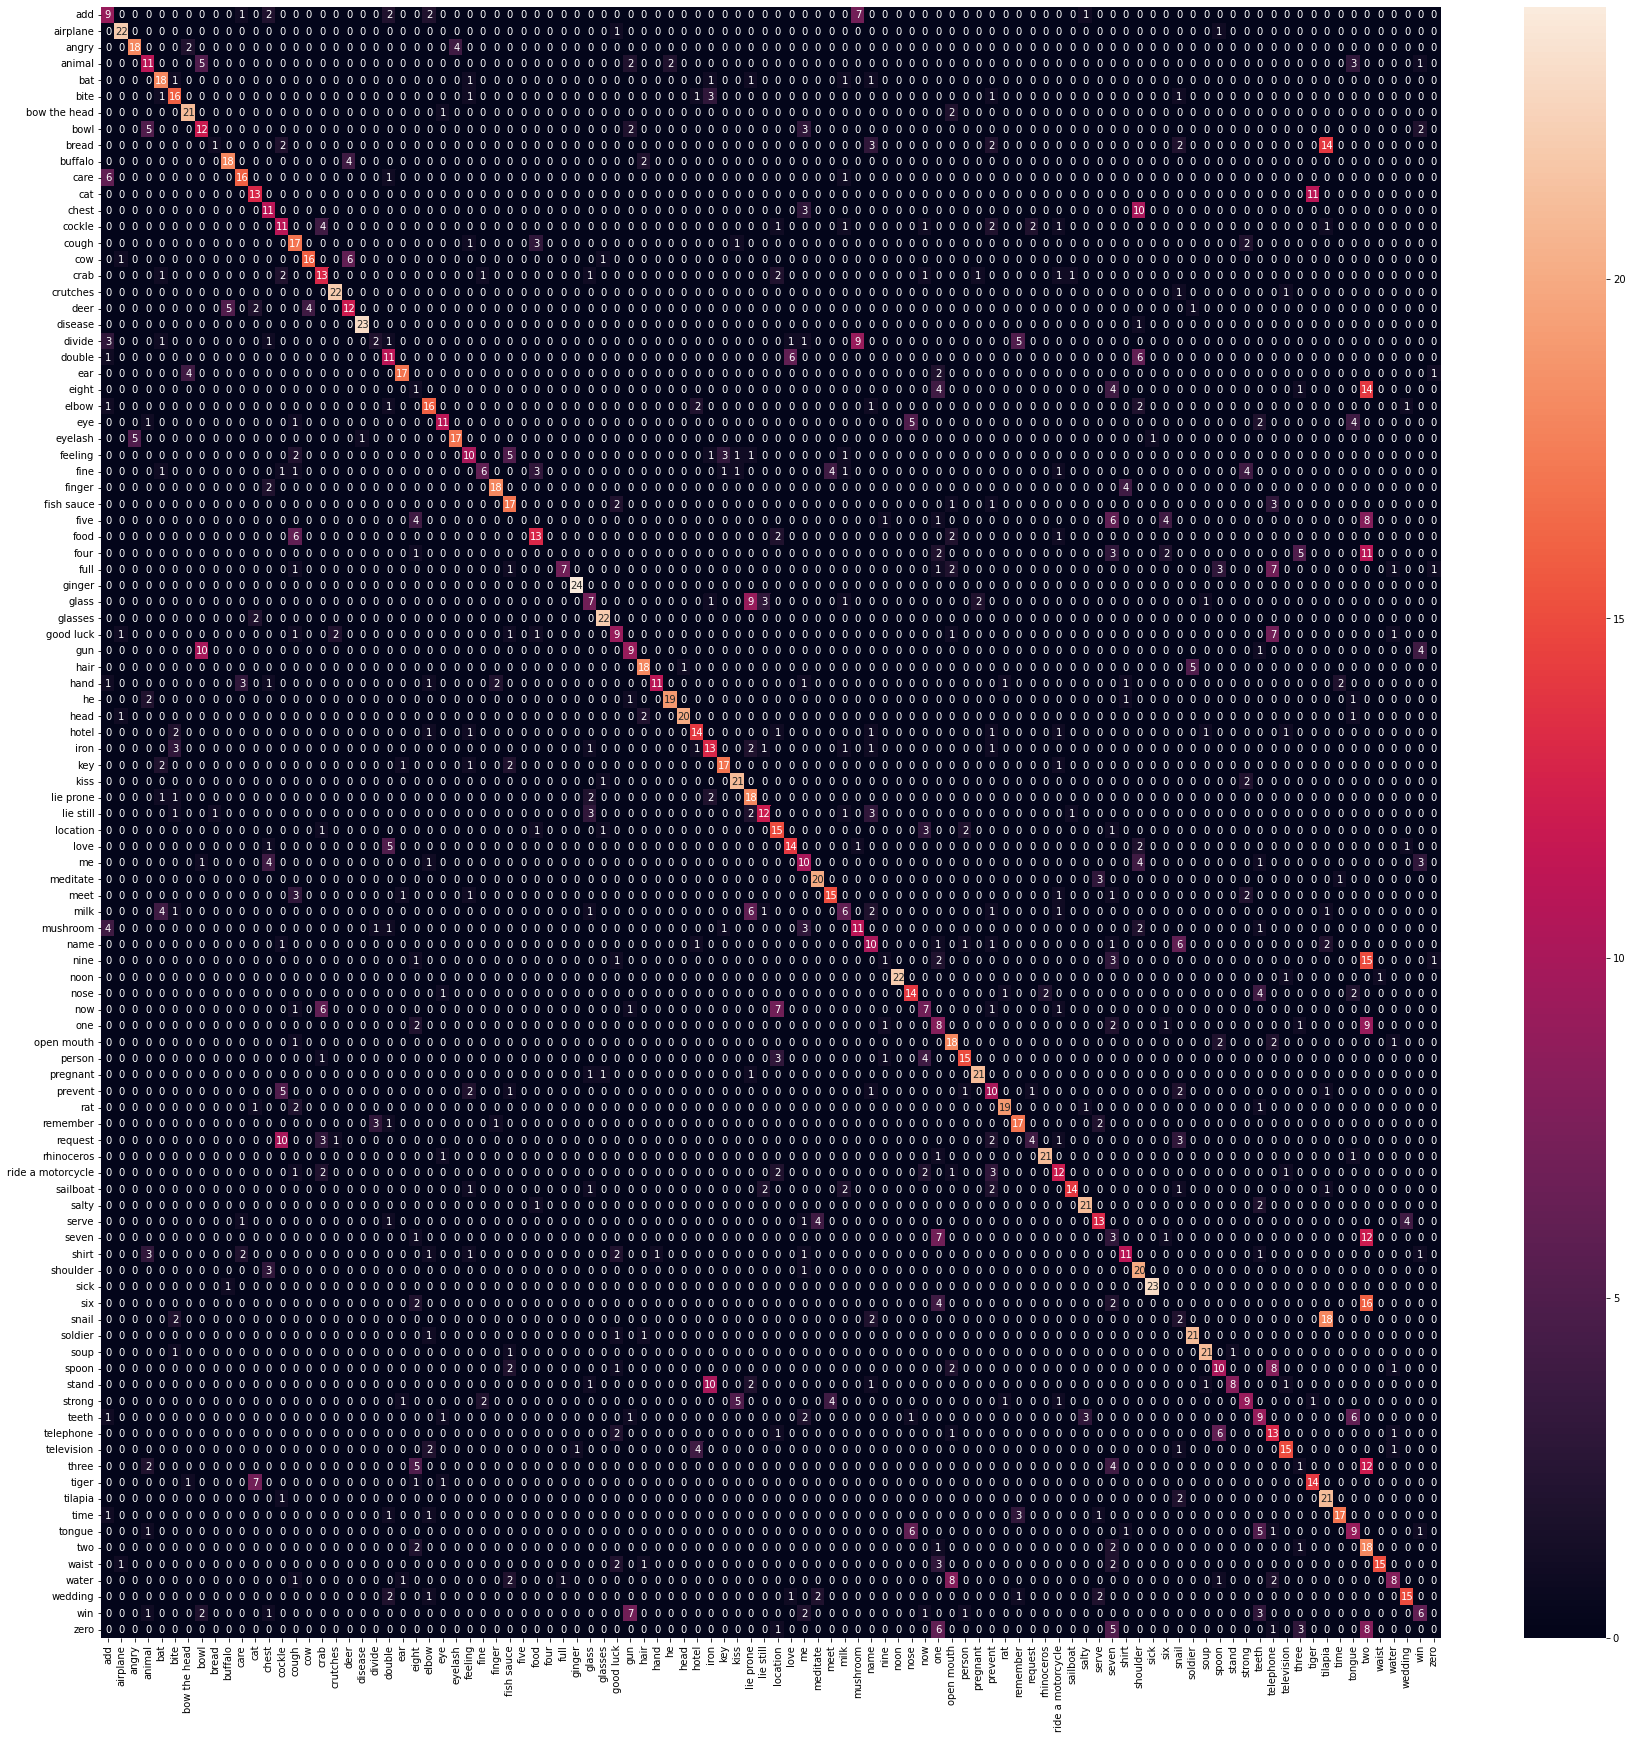

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## SGD

In [ ]:
model_MBv3L_3= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3L_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_1)
model_MBv3L_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3L_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 63s 227ms/step - loss: 4.3710 - accuracy: 0.0413 - val_loss: 4.1763 - val_accuracy: 0.1056
Epoch 2/120
262/262 [==============================] - 60s 227ms/step - loss: 4.3695 - accuracy: 0.0423 - val_loss: 4.1726 - val_accuracy: 0.1081
Epoch 3/120
262/262 [==============================] - 62s 238ms/step - loss: 4.3653 - accuracy: 0.0397 - val_loss: 4.1694 - val_accuracy: 0.1047
Epoch 4/120
262/262 [==============================] - 63s 240ms/step - loss: 4.3707 - accuracy: 0.0394 - val_loss: 4.1639 - val_accuracy: 0.1098
Epoch 5/120
262/262 [==============================] - 62s 236ms/step - loss: 4.3435 - accuracy: 0.0421 - val_loss: 4.1571 - val_accuracy: 0.1064
Epoch 6/120
262/262 [==============================] - 61s 232ms/step - loss: 4.3468 - accuracy: 0.0441 - val_loss: 4.1631 - val_accuracy: 0.1081
Epoch 7/120
262/262 [==============================] - 58s 219ms/step - loss: 4.3554 - accuracy: 0.0421 - val_loss: 4.1542 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
from keras.models import load_model
model_MBv3L_3 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_1.h5')

In [ ]:
SAVE_model_MBv3L_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_2)
model_MBv3L_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3L_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 65s 231ms/step - loss: 3.9031 - accuracy: 0.0759 - val_loss: 3.6810 - val_accuracy: 0.1731
Epoch 2/75
262/262 [==============================] - 58s 223ms/step - loss: 3.9091 - accuracy: 0.0771 - val_loss: 3.6740 - val_accuracy: 0.1723
Epoch 3/75
262/262 [==============================] - 59s 227ms/step - loss: 3.9017 - accuracy: 0.0759 - val_loss: 3.6747 - val_accuracy: 0.1723
Epoch 4/75
262/262 [==============================] - 60s 231ms/step - loss: 3.9021 - accuracy: 0.0743 - val_loss: 3.6681 - val_accuracy: 0.1740
Epoch 5/75
262/262 [==============================] - 63s 239ms/step - loss: 3.9020 - accuracy: 0.0719 - val_loss: 3.6749 - val_accuracy: 0.1731
Epoch 6/75
262/262 [==============================] - 61s 234ms/step - loss: 3.9094 - accuracy: 0.0725 - val_loss: 3.6689 - val_accuracy: 0.1731
Epoch 7/75
262/262 [==============================] - 63s 239ms/step - loss: 3.8998 - accuracy: 0.0727 - val_loss: 3.6702 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3L_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_3)
model_MBv3L_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3L_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 73s 264ms/step - loss: 3.8734 - accuracy: 0.0766 - val_loss: 3.6442 - val_accuracy: 0.1807
Epoch 2/75
262/262 [==============================] - 64s 245ms/step - loss: 3.8759 - accuracy: 0.0780 - val_loss: 3.6505 - val_accuracy: 0.1799
Epoch 3/75
262/262 [==============================] - 66s 252ms/step - loss: 3.8957 - accuracy: 0.0694 - val_loss: 3.6458 - val_accuracy: 0.1731
Epoch 4/75
262/262 [==============================] - 67s 256ms/step - loss: 3.8883 - accuracy: 0.0742 - val_loss: 3.6460 - val_accuracy: 0.1850
Epoch 5/75
262/262 [==============================] - 67s 256ms/step - loss: 3.8854 - accuracy: 0.0735 - val_loss: 3.6387 - val_accuracy: 0.1816
Epoch 6/75
262/262 [==============================] - 66s 253ms/step - loss: 3.8912 - accuracy: 0.0735 - val_loss: 3.6431 - val_accuracy: 0.1807
Epoch 7/75
262/262 [==============================] - 67s 254ms/step - loss: 3.8794 - accuracy: 0.0748 - val_loss: 3.6475 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3L_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3L_4)
model_MBv3L_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3L_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 71s 255ms/step - loss: 3.8835 - accuracy: 0.0782 - val_loss: 3.6416 - val_accuracy: 0.1791
Epoch 2/30
262/262 [==============================] - 68s 258ms/step - loss: 3.8708 - accuracy: 0.0776 - val_loss: 3.6472 - val_accuracy: 0.1774
Epoch 3/30
262/262 [==============================] - 67s 257ms/step - loss: 3.8777 - accuracy: 0.0743 - val_loss: 3.6420 - val_accuracy: 0.1791
Epoch 4/30
262/262 [==============================] - 73s 277ms/step - loss: 3.8809 - accuracy: 0.0724 - val_loss: 3.6384 - val_accuracy: 0.1858
Epoch 5/30
262/262 [==============================] - 73s 277ms/step - loss: 3.8749 - accuracy: 0.0761 - val_loss: 3.6345 - val_accuracy: 0.1799
Epoch 6/30
262/262 [==============================] - 75s 285ms/step - loss: 3.8789 - accuracy: 0.0766 - val_loss: 3.6351 - val_accuracy: 0.1867
Epoch 7/30
262/262 [==============================] - 71s 272ms/step - loss: 3.8692 - accuracy: 0.0750 - val_loss: 3.6389 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 20s 254ms/step - loss: 3.6137 - accuracy: 0.1704
test_acc: 0.1704166680574417
test_loss: 3.6137120723724365


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

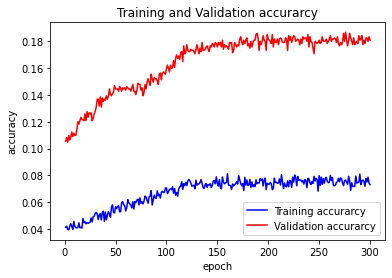

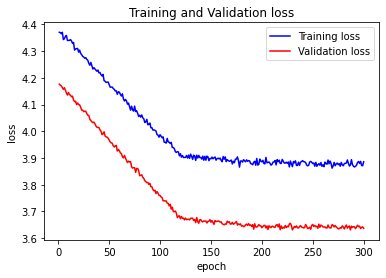

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/model_MBv3L.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp7hg5tpt8/assets


INFO:tensorflow:Assets written to: /tmp/tmp7hg5tpt8/assets


13070604

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.50      0.04      0.08        24
         airplane       0.00      0.00      0.00        24
            angry       0.12      0.25      0.16        24
           animal       0.00      0.00      0.00        24
              bat       0.00      0.00      0.00        24
             bite       0.00      0.00      0.00        24
     bow the head       1.00      0.04      0.08        24
             bowl       0.18      0.25      0.21        24
            bread       0.14      0.04      0.06        24
          buffalo       0.40      0.67      0.50        24
             care       0.35      0.58      0.44        24
              cat       0.29      0.21      0.24        24
            chest       0.40      0.08      0.14        24
           cockle       0.07      0.42      0.12        24
            cough       0.08      0.04      0.06        24
              cow       0.33      0.58      0.42       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


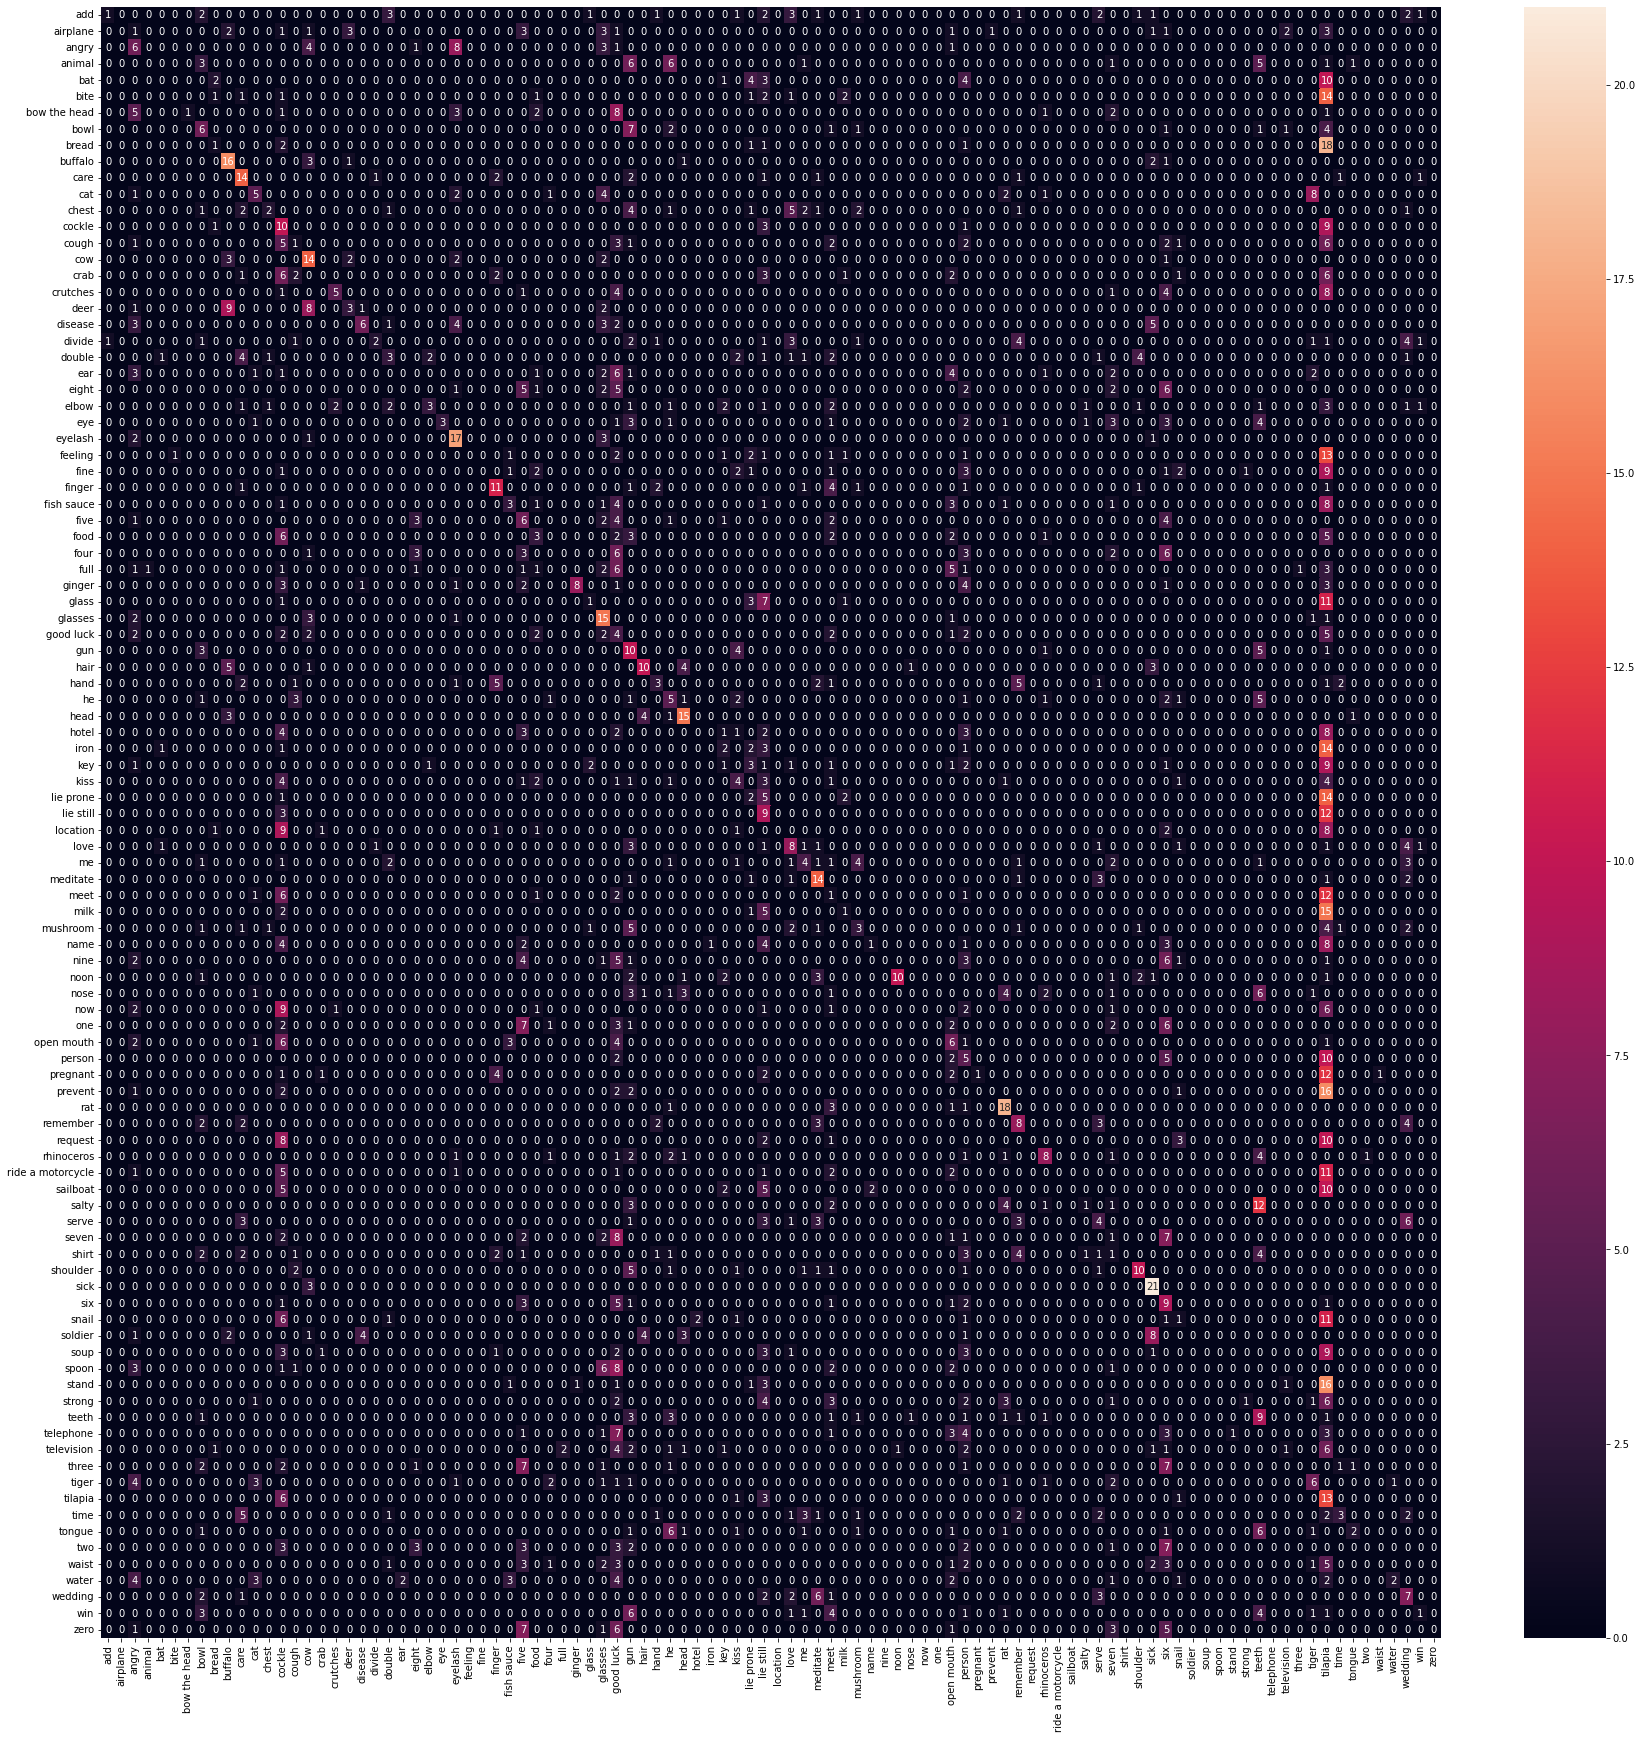

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

##Recap graph MobileNetV3Large

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

Path_Adam = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/Adam/history.csv'
with open(Path_Adam, 'rb') as handle:
    his_Adam = load(handle)

Path_rmsProp = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/rmsProp/history.csv'
with open(Path_rmsProp , 'rb') as handle:
    his_rmsProp = load(handle)

Path_SGD = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Large/SGD/history.csv'
with open(Path_SGD, 'rb') as handle:
    his_SGD = load(handle)



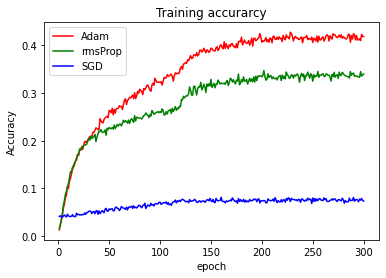

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Accuracy
acc1 = his_Adam['accuracy']
acc2 = his_rmsProp['accuracy']
acc3 = his_SGD['accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training accurarcy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()


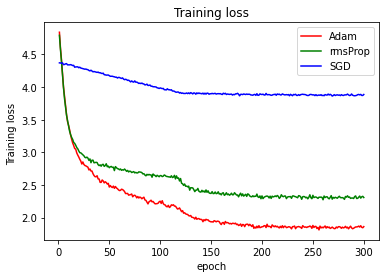

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Loss
acc1 = his_Adam['loss']
acc2 = his_rmsProp['loss']
acc3 = his_SGD['loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training loss')
plt.ylabel('Training loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

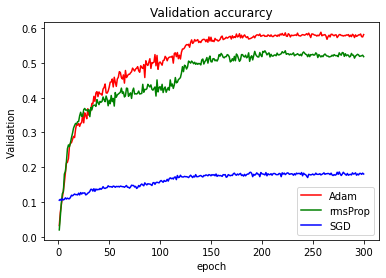

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Accuracy
acc1 = his_Adam['val_accuracy']
acc2 = his_rmsProp['val_accuracy']
acc3 = his_SGD['val_accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation accurarcy')
plt.ylabel('Validation ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

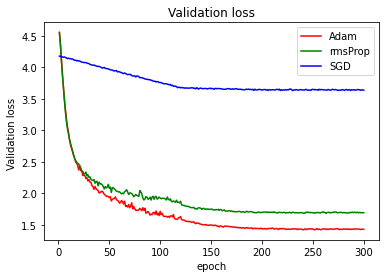

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Loss
acc1 = his_Adam['val_loss']
acc2 = his_rmsProp['val_loss']
acc3 = his_SGD['val_loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation loss')
plt.ylabel('Validation loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

#MobileNetV3Small

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [ ]:
conv_base_MobileNet  = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(SIZE,SIZE,CHANNEL))

4349952/4334752 [==============================] - 0s 0us/step


In [ ]:
for layer in conv_base_MobileNet.layers:
  layer.trainable = False

In [ ]:
for i, layer in enumerate(conv_base_MobileNet.layers):
  print(i, layer.name, "-", layer.trainable)

In [ ]:
def create_model (conv_base):
  x=conv_base_MobileNet.output
  x=GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x=Dense(256, activation='relu')(x) 

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(128, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)

  x=Dense(64, activation='relu')(x)

  x = Dropout(0.5)(x)
  x = BatchNormalization()(x) 

  preds=Dense(NUM_CLASS, activation='softmax')(x) #final layer with softmax activation

  model=Model(inputs=conv_base_MobileNet.input, outputs=preds)
  model.summary()
  return model

## Adam

In [ ]:
model_MBv3S_1= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3S_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_1)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 42s 146ms/step - loss: 4.8421 - accuracy: 0.0125 - val_loss: 4.6044 - val_accuracy: 0.0160
Epoch 2/120
262/262 [==============================] - 38s 146ms/step - loss: 4.5809 - accuracy: 0.0227 - val_loss: 4.4339 - val_accuracy: 0.0498
Epoch 3/120
262/262 [==============================] - 38s 144ms/step - loss: 4.3474 - accuracy: 0.0402 - val_loss: 4.0711 - val_accuracy: 0.0828
Epoch 4/120
262/262 [==============================] - 36s 138ms/step - loss: 4.1395 - accuracy: 0.0477 - val_loss: 3.7882 - val_accuracy: 0.1090
Epoch 5/120
262/262 [==============================] - 38s 147ms/step - loss: 3.9465 - accuracy: 0.0571 - val_loss: 3.5757 - val_accuracy: 0.1191
Epoch 6/120
262/262 [==============================] - 38s 143ms/step - loss: 3.8034 - accuracy: 0.0590 - val_loss: 3.4286 - val_accuracy: 0.1377
Epoch 7/120
262/262 [==============================] - 33s 127ms/step - loss: 3.6805 - accuracy: 0.0740 - val_loss: 3.2917 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3S_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_2)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 45s 157ms/step - loss: 2.2567 - accuracy: 0.3011 - val_loss: 1.6222 - val_accuracy: 0.4992
Epoch 2/75
262/262 [==============================] - 36s 137ms/step - loss: 2.2233 - accuracy: 0.3058 - val_loss: 1.6145 - val_accuracy: 0.4941
Epoch 3/75
262/262 [==============================] - 37s 139ms/step - loss: 2.2329 - accuracy: 0.3084 - val_loss: 1.6145 - val_accuracy: 0.5034
Epoch 4/75
262/262 [==============================] - 37s 141ms/step - loss: 2.1898 - accuracy: 0.3127 - val_loss: 1.6049 - val_accuracy: 0.5042
Epoch 5/75
262/262 [==============================] - 37s 141ms/step - loss: 2.1962 - accuracy: 0.3121 - val_loss: 1.5867 - val_accuracy: 0.5177
Epoch 6/75
262/262 [==============================] - 37s 139ms/step - loss: 2.1889 - accuracy: 0.3272 - val_loss: 1.5934 - val_accuracy: 0.5059
Epoch 7/75
262/262 [==============================] - 37s 140ms/step - loss: 2.1808 - accuracy: 0.3213 - val_loss: 1.5849 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5| 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3S_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_3)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 47s 162ms/step - loss: 2.0372 - accuracy: 0.3510 - val_loss: 1.4622 - val_accuracy: 0.5431
Epoch 2/75
262/262 [==============================] - 38s 147ms/step - loss: 2.0373 - accuracy: 0.3531 - val_loss: 1.4611 - val_accuracy: 0.5456
Epoch 3/75
262/262 [==============================] - 37s 143ms/step - loss: 2.0239 - accuracy: 0.3657 - val_loss: 1.4659 - val_accuracy: 0.5422
Epoch 4/75
262/262 [==============================] - 37s 141ms/step - loss: 2.0213 - accuracy: 0.3556 - val_loss: 1.4702 - val_accuracy: 0.5498
Epoch 5/75
262/262 [==============================] - 37s 141ms/step - loss: 2.0076 - accuracy: 0.3634 - val_loss: 1.4658 - val_accuracy: 0.5473
Epoch 6/75
262/262 [==============================] - 38s 143ms/step - loss: 2.0396 - accuracy: 0.3531 - val_loss: 1.4605 - val_accuracy: 0.5473
Epoch 7/75
262/262 [==============================] - 37s 142ms/step - loss: 2.0401 - accuracy: 0.3555 - val_loss: 1.4639 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6| 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3S_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_4)
model_MBv3S_1.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3S_1.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 41s 143ms/step - loss: 2.0236 - accuracy: 0.3566 - val_loss: 1.4479 - val_accuracy: 0.5583
Epoch 2/30
262/262 [==============================] - 38s 146ms/step - loss: 2.0235 - accuracy: 0.3521 - val_loss: 1.4548 - val_accuracy: 0.5515
Epoch 3/30
262/262 [==============================] - 39s 149ms/step - loss: 1.9987 - accuracy: 0.3554 - val_loss: 1.4517 - val_accuracy: 0.5498
Epoch 4/30
262/262 [==============================] - 40s 153ms/step - loss: 2.0128 - accuracy: 0.3613 - val_loss: 1.4490 - val_accuracy: 0.5557
Epoch 5/30
262/262 [==============================] - 40s 152ms/step - loss: 1.9992 - accuracy: 0.3732 - val_loss: 1.4512 - val_accuracy: 0.5557
Epoch 6/30
262/262 [==============================] - 39s 150ms/step - loss: 2.0170 - accuracy: 0.3668 - val_loss: 1.4539 - val_accuracy: 0.5490
Epoch 7/30
262/262 [==============================] - 41s 157ms/step - loss: 2.0074 - accuracy: 0.3535 - val_loss: 1.4534 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 15s 181ms/step - loss: 1.4023 - accuracy: 0.6062
test_acc: 0.606249988079071
test_loss: 1.402264952659607


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

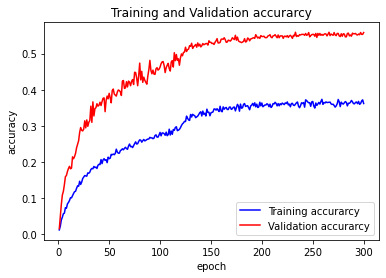

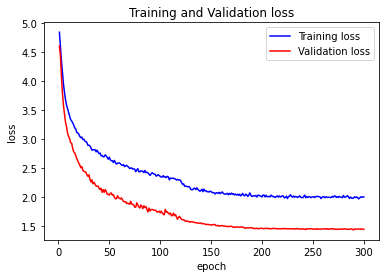

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/model_MBv3S.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpfx8sl7_z/assets


INFO:tensorflow:Assets written to: /tmp/tmpfx8sl7_z/assets


4515436

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.31      0.42      0.36        24
         airplane       0.84      0.88      0.86        24
            angry       0.64      0.58      0.61        24
           animal       0.35      0.38      0.36        24
              bat       0.85      0.71      0.77        24
             bite       0.81      0.92      0.86        24
     bow the head       0.71      0.92      0.80        24
             bowl       0.58      0.75      0.65        24
            bread       0.25      0.17      0.20        24
          buffalo       0.81      0.88      0.84        24
             care       0.65      0.54      0.59        24
              cat       0.66      0.96      0.78        24
            chest       0.59      0.67      0.63        24
           cockle       0.47      0.62      0.54        24
            cough       0.50      0.58      0.54        24
              cow       0.71      0.62      0.67       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


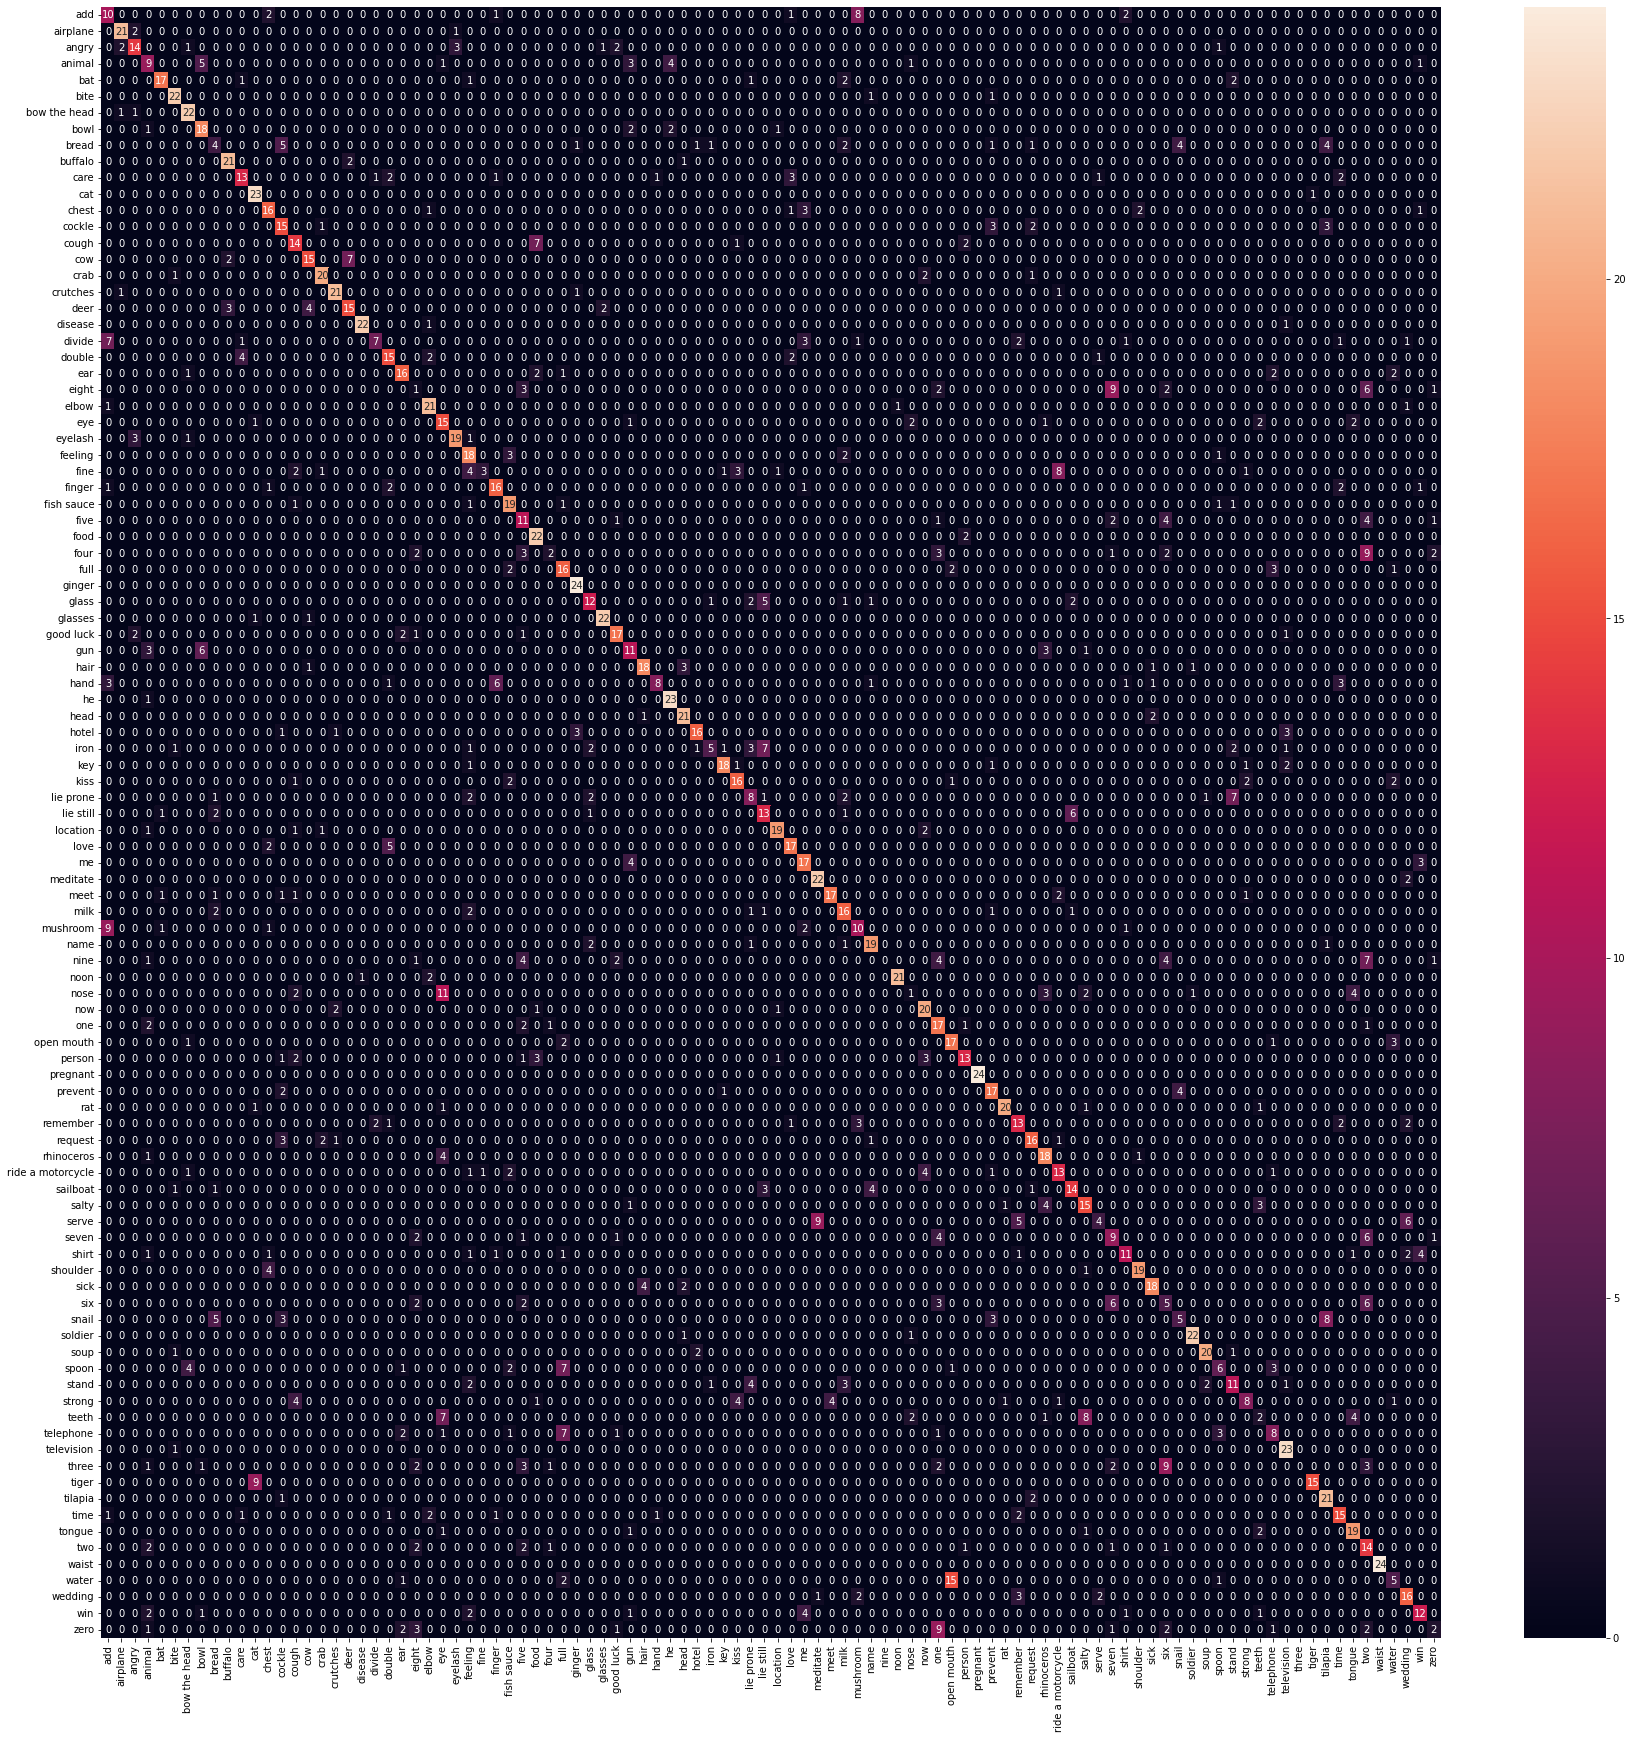

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## rmsProp

In [ ]:
model_MBv3S_2= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3S_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_1)
model_MBv3S_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3S_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 40s 136ms/step - loss: 4.8120 - accuracy: 0.0116 - val_loss: 4.6140 - val_accuracy: 0.0101
Epoch 2/120
262/262 [==============================] - 36s 136ms/step - loss: 4.6059 - accuracy: 0.0197 - val_loss: 4.4796 - val_accuracy: 0.0329
Epoch 3/120
262/262 [==============================] - 35s 133ms/step - loss: 4.3593 - accuracy: 0.0359 - val_loss: 4.0932 - val_accuracy: 0.0743
Epoch 4/120
262/262 [==============================] - 35s 133ms/step - loss: 4.1330 - accuracy: 0.0448 - val_loss: 3.8071 - val_accuracy: 0.0971
Epoch 5/120
262/262 [==============================] - 35s 134ms/step - loss: 3.9462 - accuracy: 0.0575 - val_loss: 3.6433 - val_accuracy: 0.1267
Epoch 6/120
262/262 [==============================] - 37s 142ms/step - loss: 3.8117 - accuracy: 0.0655 - val_loss: 3.4709 - val_accuracy: 0.1436
Epoch 7/120
262/262 [==============================] - 38s 145ms/step - loss: 3.6993 - accuracy: 0.0764 - val_loss: 3.3306 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3S_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_2)
model_MBv3S_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3S_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 42s 144ms/step - loss: 2.6930 - accuracy: 0.2420 - val_loss: 1.8851 - val_accuracy: 0.4367
Epoch 2/75
262/262 [==============================] - 36s 136ms/step - loss: 2.6612 - accuracy: 0.2477 - val_loss: 1.8713 - val_accuracy: 0.4552
Epoch 3/75
262/262 [==============================] - 35s 135ms/step - loss: 2.6518 - accuracy: 0.2561 - val_loss: 1.8589 - val_accuracy: 0.4552
Epoch 4/75
262/262 [==============================] - 35s 133ms/step - loss: 2.6265 - accuracy: 0.2475 - val_loss: 1.8453 - val_accuracy: 0.4688
Epoch 5/75
262/262 [==============================] - 35s 132ms/step - loss: 2.5958 - accuracy: 0.2597 - val_loss: 1.8365 - val_accuracy: 0.4671
Epoch 6/75
262/262 [==============================] - 35s 135ms/step - loss: 2.5899 - accuracy: 0.2663 - val_loss: 1.8217 - val_accuracy: 0.4713
Epoch 7/75
262/262 [==============================] - 35s 135ms/step - loss: 2.5854 - accuracy: 0.2610 - val_loss: 1.8233 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
from keras.models import load_model
model_MBv3S_2 = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_2.h5')

In [ ]:
SAVE_model_MBv3S_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_3)
model_MBv3S_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3S_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 36s 121ms/step - loss: 2.4482 - accuracy: 0.2927 - val_loss: 1.7278 - val_accuracy: 0.4966
Epoch 2/75
262/262 [==============================] - 31s 118ms/step - loss: 2.4262 - accuracy: 0.2955 - val_loss: 1.7221 - val_accuracy: 0.5034
Epoch 3/75
262/262 [==============================] - 30s 115ms/step - loss: 2.4334 - accuracy: 0.2983 - val_loss: 1.7210 - val_accuracy: 0.5042
Epoch 4/75
262/262 [==============================] - 30s 114ms/step - loss: 2.4043 - accuracy: 0.3045 - val_loss: 1.7201 - val_accuracy: 0.5093
Epoch 5/75
262/262 [==============================] - 30s 115ms/step - loss: 2.4382 - accuracy: 0.2921 - val_loss: 1.7266 - val_accuracy: 0.5093
Epoch 6/75
262/262 [==============================] - 30s 114ms/step - loss: 2.4599 - accuracy: 0.2882 - val_loss: 1.7197 - val_accuracy: 0.5084
Epoch 7/75
262/262 [==============================] - 30s 113ms/step - loss: 2.4425 - accuracy: 0.3009 - val_loss: 1.7217 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3S_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.RMSprop(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_4)
model_MBv3S_2.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3S_2.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 36s 120ms/step - loss: 2.4088 - accuracy: 0.3034 - val_loss: 1.7060 - val_accuracy: 0.5118
Epoch 2/30
262/262 [==============================] - 32s 121ms/step - loss: 2.4251 - accuracy: 0.2976 - val_loss: 1.7140 - val_accuracy: 0.5118
Epoch 3/30
262/262 [==============================] - 32s 121ms/step - loss: 2.4257 - accuracy: 0.2997 - val_loss: 1.7181 - val_accuracy: 0.5101
Epoch 4/30
262/262 [==============================] - 32s 121ms/step - loss: 2.4120 - accuracy: 0.3031 - val_loss: 1.7094 - val_accuracy: 0.5093
Epoch 5/30
262/262 [==============================] - 32s 121ms/step - loss: 2.4185 - accuracy: 0.3009 - val_loss: 1.7092 - val_accuracy: 0.5160
Epoch 6/30
262/262 [==============================] - 31s 120ms/step - loss: 2.4006 - accuracy: 0.3008 - val_loss: 1.7144 - val_accuracy: 0.5160
Epoch 7/30
262/262 [==============================] - 32s 121ms/step - loss: 2.4144 - accuracy: 0.3059 - val_loss: 1.7084 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 9s 99ms/step - loss: 1.6684 - accuracy: 0.5446
test_acc: 0.5445833206176758
test_loss: 1.6683845520019531


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

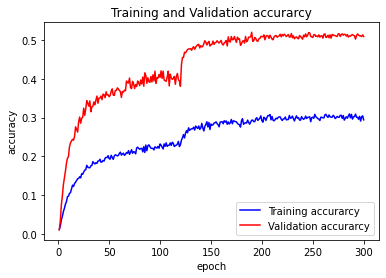

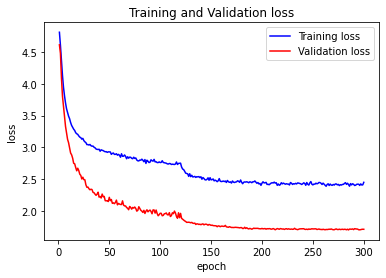

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/model_MBv3S.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpnqesnd6h/assets


4515468

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.18      0.21      0.19        24
         airplane       0.95      0.79      0.86        24
            angry       0.53      0.38      0.44        24
           animal       0.54      0.29      0.38        24
              bat       0.36      0.33      0.35        24
             bite       0.84      0.88      0.86        24
     bow the head       0.64      0.67      0.65        24
             bowl       0.44      0.71      0.54        24
            bread       0.40      0.25      0.31        24
          buffalo       0.84      0.88      0.86        24
             care       0.31      0.46      0.37        24
              cat       0.65      1.00      0.79        24
            chest       0.52      0.62      0.57        24
           cockle       0.21      0.21      0.21        24
            cough       0.43      0.54      0.48        24
              cow       0.75      0.75      0.75       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


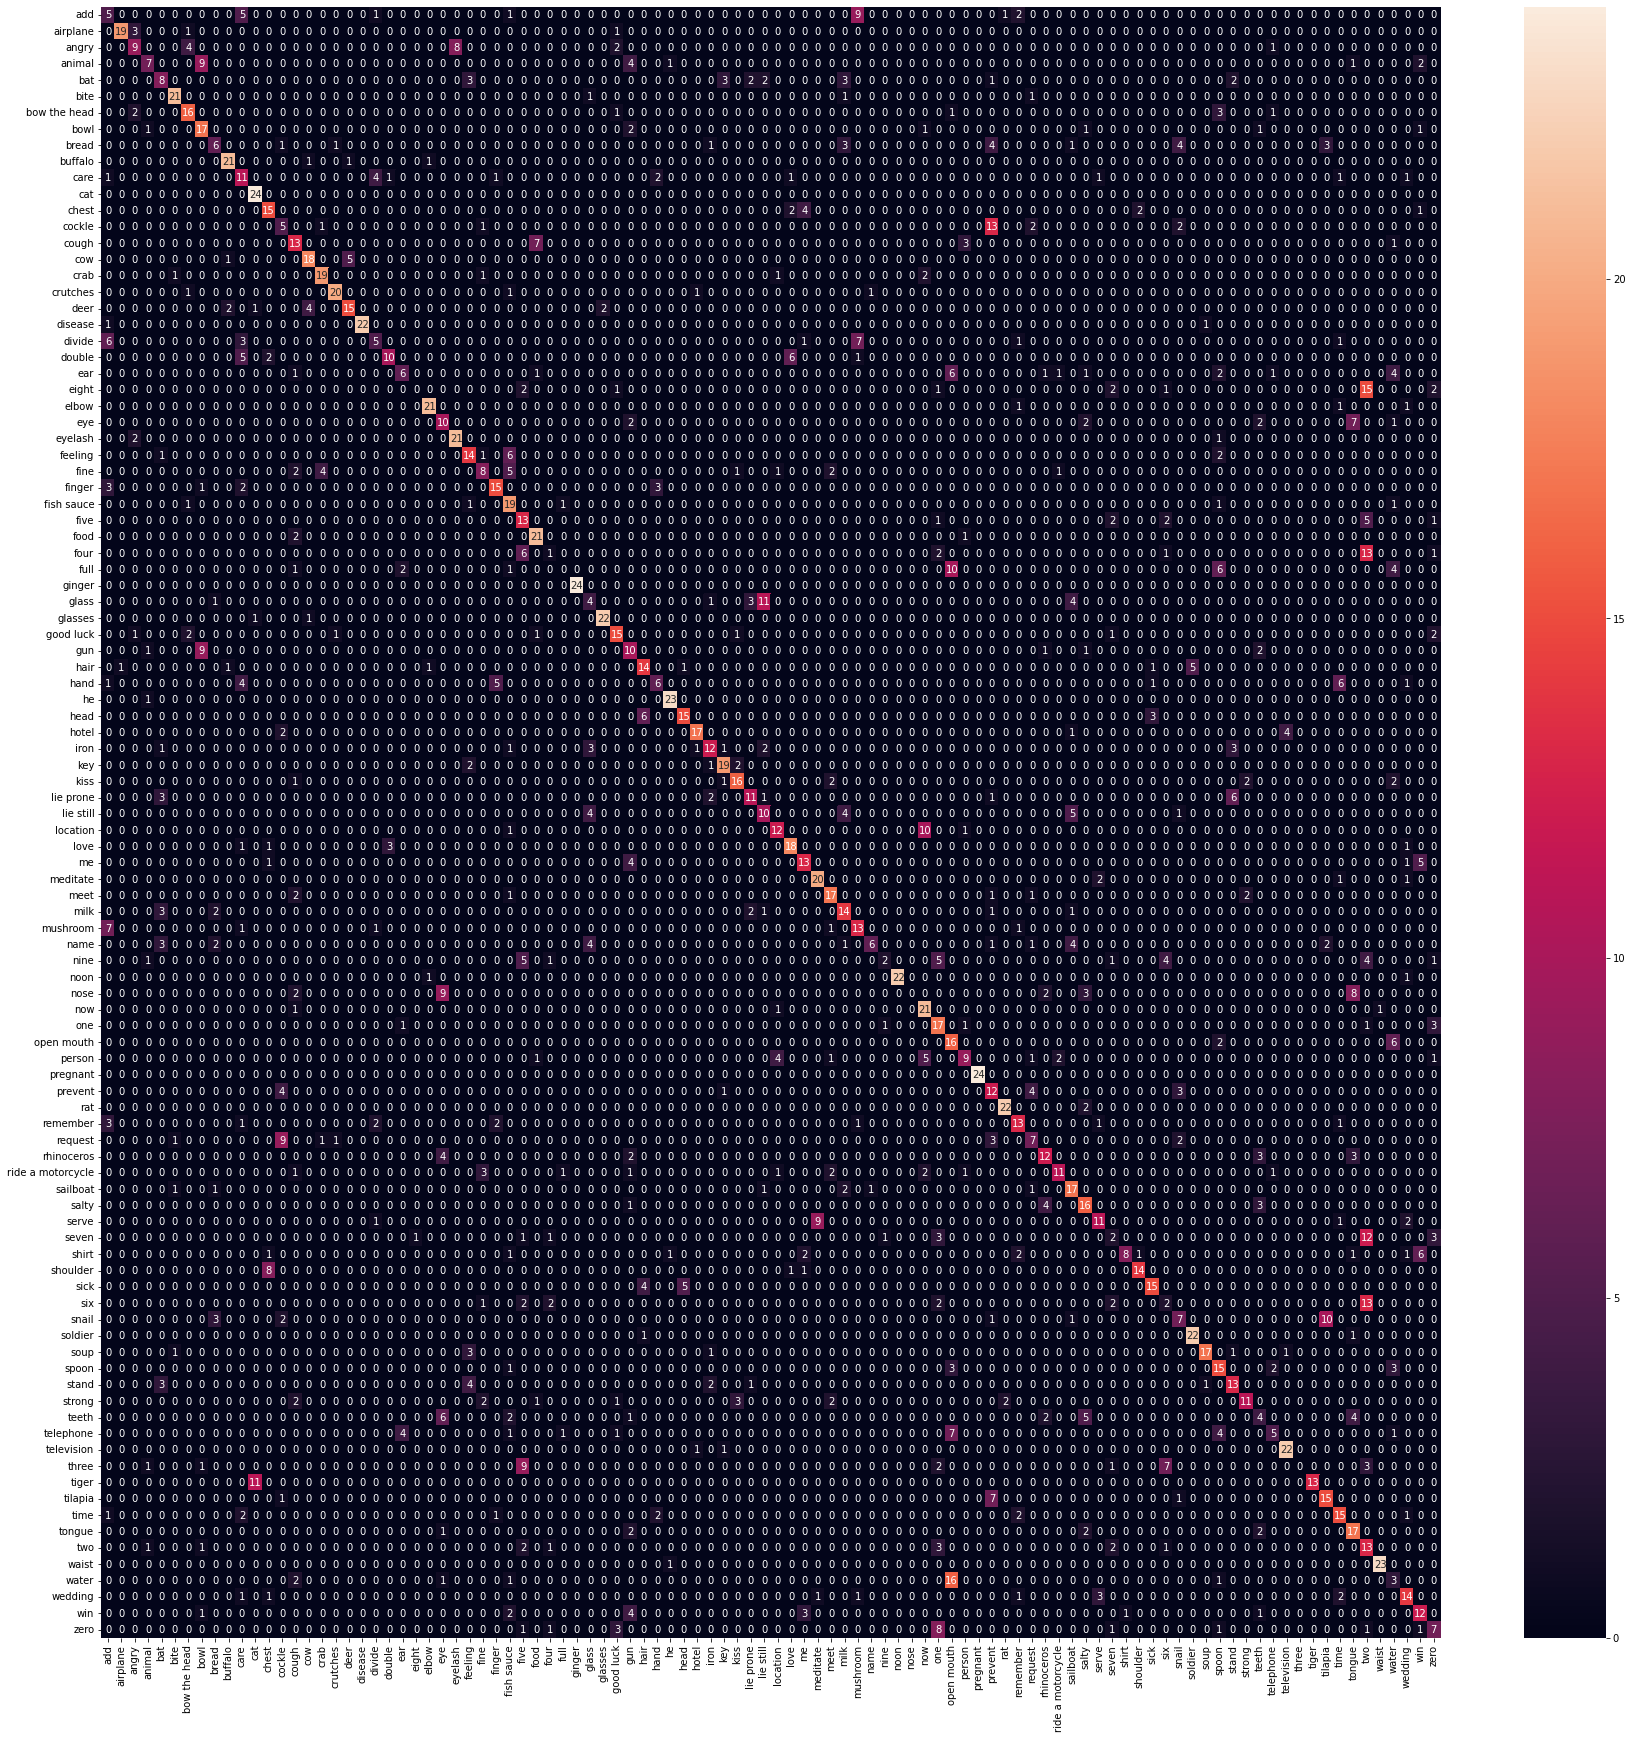

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

## SGD

In [ ]:
model_MBv3S_3= create_model(conv_base_MobileNet)

### lr = 1x10-3 | 120/300 epoch [40%]

In [ ]:
SAVE_model_MBv3S_1 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S_1.h5'
EPOCH = 120
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_1)
model_MBv3S_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_1= model_MBv3S_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/120
262/262 [==============================] - 39s 133ms/step - loss: 4.9650 - accuracy: 0.0099 - val_loss: 4.6355 - val_accuracy: 0.0101
Epoch 2/120
262/262 [==============================] - 33s 128ms/step - loss: 4.9799 - accuracy: 0.0081 - val_loss: 4.6304 - val_accuracy: 0.0152
Epoch 3/120
262/262 [==============================] - 33s 125ms/step - loss: 4.9654 - accuracy: 0.0105 - val_loss: 4.6269 - val_accuracy: 0.0101
Epoch 4/120
262/262 [==============================] - 34s 130ms/step - loss: 4.9586 - accuracy: 0.0097 - val_loss: 4.6222 - val_accuracy: 0.0118
Epoch 5/120
262/262 [==============================] - 36s 136ms/step - loss: 4.9265 - accuracy: 0.0099 - val_loss: 4.6137 - val_accuracy: 0.0127
Epoch 6/120
262/262 [==============================] - 35s 134ms/step - loss: 4.9448 - accuracy: 0.0105 - val_loss: 4.6100 - val_accuracy: 0.0169
Epoch 7/120
262/262 [==============================] - 36s 137ms/step - loss: 4.9213 - accuracy: 0.0109 - val_loss: 4.6013 -

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_1.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_1.history, file_pi)

### lr = 1x10-4 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3S_2 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S_2.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.0001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_2)
model_MBv3S_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_2= model_MBv3S_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 42s 144ms/step - loss: 4.3213 - accuracy: 0.0418 - val_loss: 4.1109 - val_accuracy: 0.0811
Epoch 2/75
262/262 [==============================] - 35s 132ms/step - loss: 4.3360 - accuracy: 0.0405 - val_loss: 4.1056 - val_accuracy: 0.0828
Epoch 3/75
262/262 [==============================] - 35s 133ms/step - loss: 4.3220 - accuracy: 0.0430 - val_loss: 4.1139 - val_accuracy: 0.0802
Epoch 4/75
262/262 [==============================] - 35s 132ms/step - loss: 4.3317 - accuracy: 0.0422 - val_loss: 4.1030 - val_accuracy: 0.0870
Epoch 5/75
262/262 [==============================] - 34s 129ms/step - loss: 4.3251 - accuracy: 0.0411 - val_loss: 4.1071 - val_accuracy: 0.0845
Epoch 6/75
262/262 [==============================] - 33s 126ms/step - loss: 4.3229 - accuracy: 0.0380 - val_loss: 4.1052 - val_accuracy: 0.0828
Epoch 7/75
262/262 [==============================] - 33s 125ms/step - loss: 4.3150 - accuracy: 0.0403 - val_loss: 4.1046 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_2.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_2.history, file_pi)

### lr = 1x10-5 | 75/300 epoch [25%]

In [ ]:
SAVE_model_MBv3S_3 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S_3.h5'
EPOCH = 75
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.00001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_3)
model_MBv3S_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_3= model_MBv3S_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/75
262/262 [==============================] - 40s 138ms/step - loss: 4.2726 - accuracy: 0.0455 - val_loss: 4.0669 - val_accuracy: 0.0887
Epoch 2/75
262/262 [==============================] - 35s 134ms/step - loss: 4.2797 - accuracy: 0.0473 - val_loss: 4.0696 - val_accuracy: 0.0853
Epoch 3/75
262/262 [==============================] - 34s 131ms/step - loss: 4.2831 - accuracy: 0.0447 - val_loss: 4.0757 - val_accuracy: 0.0861
Epoch 4/75
262/262 [==============================] - 34s 129ms/step - loss: 4.2893 - accuracy: 0.0388 - val_loss: 4.0682 - val_accuracy: 0.0811
Epoch 5/75
262/262 [==============================] - 35s 132ms/step - loss: 4.2892 - accuracy: 0.0431 - val_loss: 4.0706 - val_accuracy: 0.0836
Epoch 6/75
262/262 [==============================] - 34s 128ms/step - loss: 4.2824 - accuracy: 0.0457 - val_loss: 4.0733 - val_accuracy: 0.0861
Epoch 7/75
262/262 [==============================] - 34s 129ms/step - loss: 4.2813 - accuracy: 0.0404 - val_loss: 4.0703 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_3.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_3.history, file_pi)

### lr = 1x10-6 | 30/300 epoch [10%]

In [ ]:
SAVE_model_MBv3S_4 ='/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S_4.h5'
EPOCH = 30
opt_adam = tf.keras.optimizers.SGD(learning_rate=0.000001)
#early_stop = keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint(SAVE_model_MBv3S_4)
model_MBv3S_3.compile(optimizer= opt_adam , loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
STEP_PER_TRAIN = train_generator.n // train_generator.batch_size
STEP_PER_VAL = val_generator.n // val_generator.batch_size
history_4= model_MBv3S_3.fit(
                   train_generator,
                   steps_per_epoch = STEP_PER_TRAIN,
                   epochs = EPOCH,
                   validation_data = val_generator,
                   validation_steps = STEP_PER_VAL,
                   callbacks=[#early_stop,
                              check_point]
                   )

Epoch 1/30
262/262 [==============================] - 35s 118ms/step - loss: 4.2843 - accuracy: 0.0419 - val_loss: 4.0658 - val_accuracy: 0.0836
Epoch 2/30
262/262 [==============================] - 28s 105ms/step - loss: 4.2917 - accuracy: 0.0425 - val_loss: 4.0648 - val_accuracy: 0.0845
Epoch 3/30
262/262 [==============================] - 27s 104ms/step - loss: 4.2844 - accuracy: 0.0418 - val_loss: 4.0671 - val_accuracy: 0.0819
Epoch 4/30
262/262 [==============================] - 43s 162ms/step - loss: 4.2825 - accuracy: 0.0441 - val_loss: 4.0639 - val_accuracy: 0.0870
Epoch 5/30
262/262 [==============================] - 48s 183ms/step - loss: 4.2729 - accuracy: 0.0455 - val_loss: 4.0672 - val_accuracy: 0.0828
Epoch 6/30
262/262 [==============================] - 50s 191ms/step - loss: 4.2966 - accuracy: 0.0436 - val_loss: 4.0689 - val_accuracy: 0.0853
Epoch 7/30
262/262 [==============================] - 53s 204ms/step - loss: 4.2799 - accuracy: 0.0428 - val_loss: 4.0617 - val_ac

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_4.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(history_4.history, file_pi)

###Result 

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S_4.h5')

In [ ]:
test_loss, test_acc=model.evaluate(test_generator)
print('test_acc:', test_acc)
print('test_loss:', test_loss)

75/75 [==============================] - 8s 91ms/step - loss: 4.0405 - accuracy: 0.0979
test_acc: 0.09791667014360428
test_loss: 4.040521144866943


In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_1.csv'
with open(pathCSV  , 'rb') as handle:
    his_1= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_2.csv'
with open(pathCSV  , 'rb') as handle:
    his_2= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_3.csv'
with open(pathCSV  , 'rb') as handle:
    his_3= load(handle)

pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history_4.csv'
with open(pathCSV  , 'rb') as handle:
    his_4= load(handle)

In [ ]:
his= his_2
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_3
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

In [ ]:
his= his_4
his_1['accuracy'].extend(his['accuracy'])
his_1['val_accuracy'].extend(his['val_accuracy'])
his_1['loss'].extend(his['loss'])
his_1['val_loss'].extend(his['val_loss'])

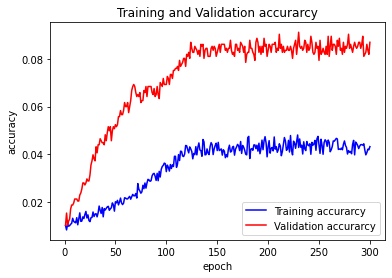

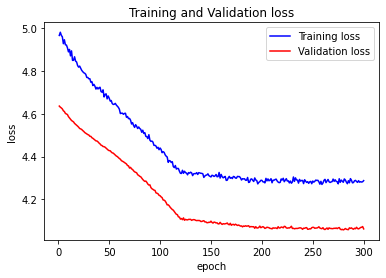

In [ ]:
acc = his_1['accuracy']
val_acc = his_1['val_accuracy']
loss = his_1['loss']
val_loss = his_1['val_loss']
epochs = range(1, len(acc)+1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# save
import pandas as pd
import pickle
pathCSV = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history.csv'

with open(pathCSV, 'wb') as file_pi:
  pickle.dump(his_1, file_pi)

In [ ]:
#tflite
import tensorflow as tf
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open ('/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/model_MBv3S.tflite', "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpw7p7im4n/assets


INFO:tensorflow:Assets written to: /tmp/tmpw7p7im4n/assets


4513972

###Evalution

In [ ]:
# test_generator -> shuffle=False
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

              add       0.00      0.00      0.00        24
         airplane       0.20      0.21      0.20        24
            angry       0.00      0.00      0.00        24
           animal       0.00      0.00      0.00        24
              bat       0.00      0.00      0.00        24
             bite       0.00      0.00      0.00        24
     bow the head       0.03      0.04      0.04        24
             bowl       0.00      0.00      0.00        24
            bread       0.00      0.00      0.00        24
          buffalo       0.21      0.17      0.19        24
             care       0.25      0.12      0.17        24
              cat       1.00      0.04      0.08        24
            chest       0.33      0.12      0.18        24
           cockle       0.00      0.00      0.00        24
            cough       0.00      0.00      0.00        24
              cow       0.15      0.58      0.24       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


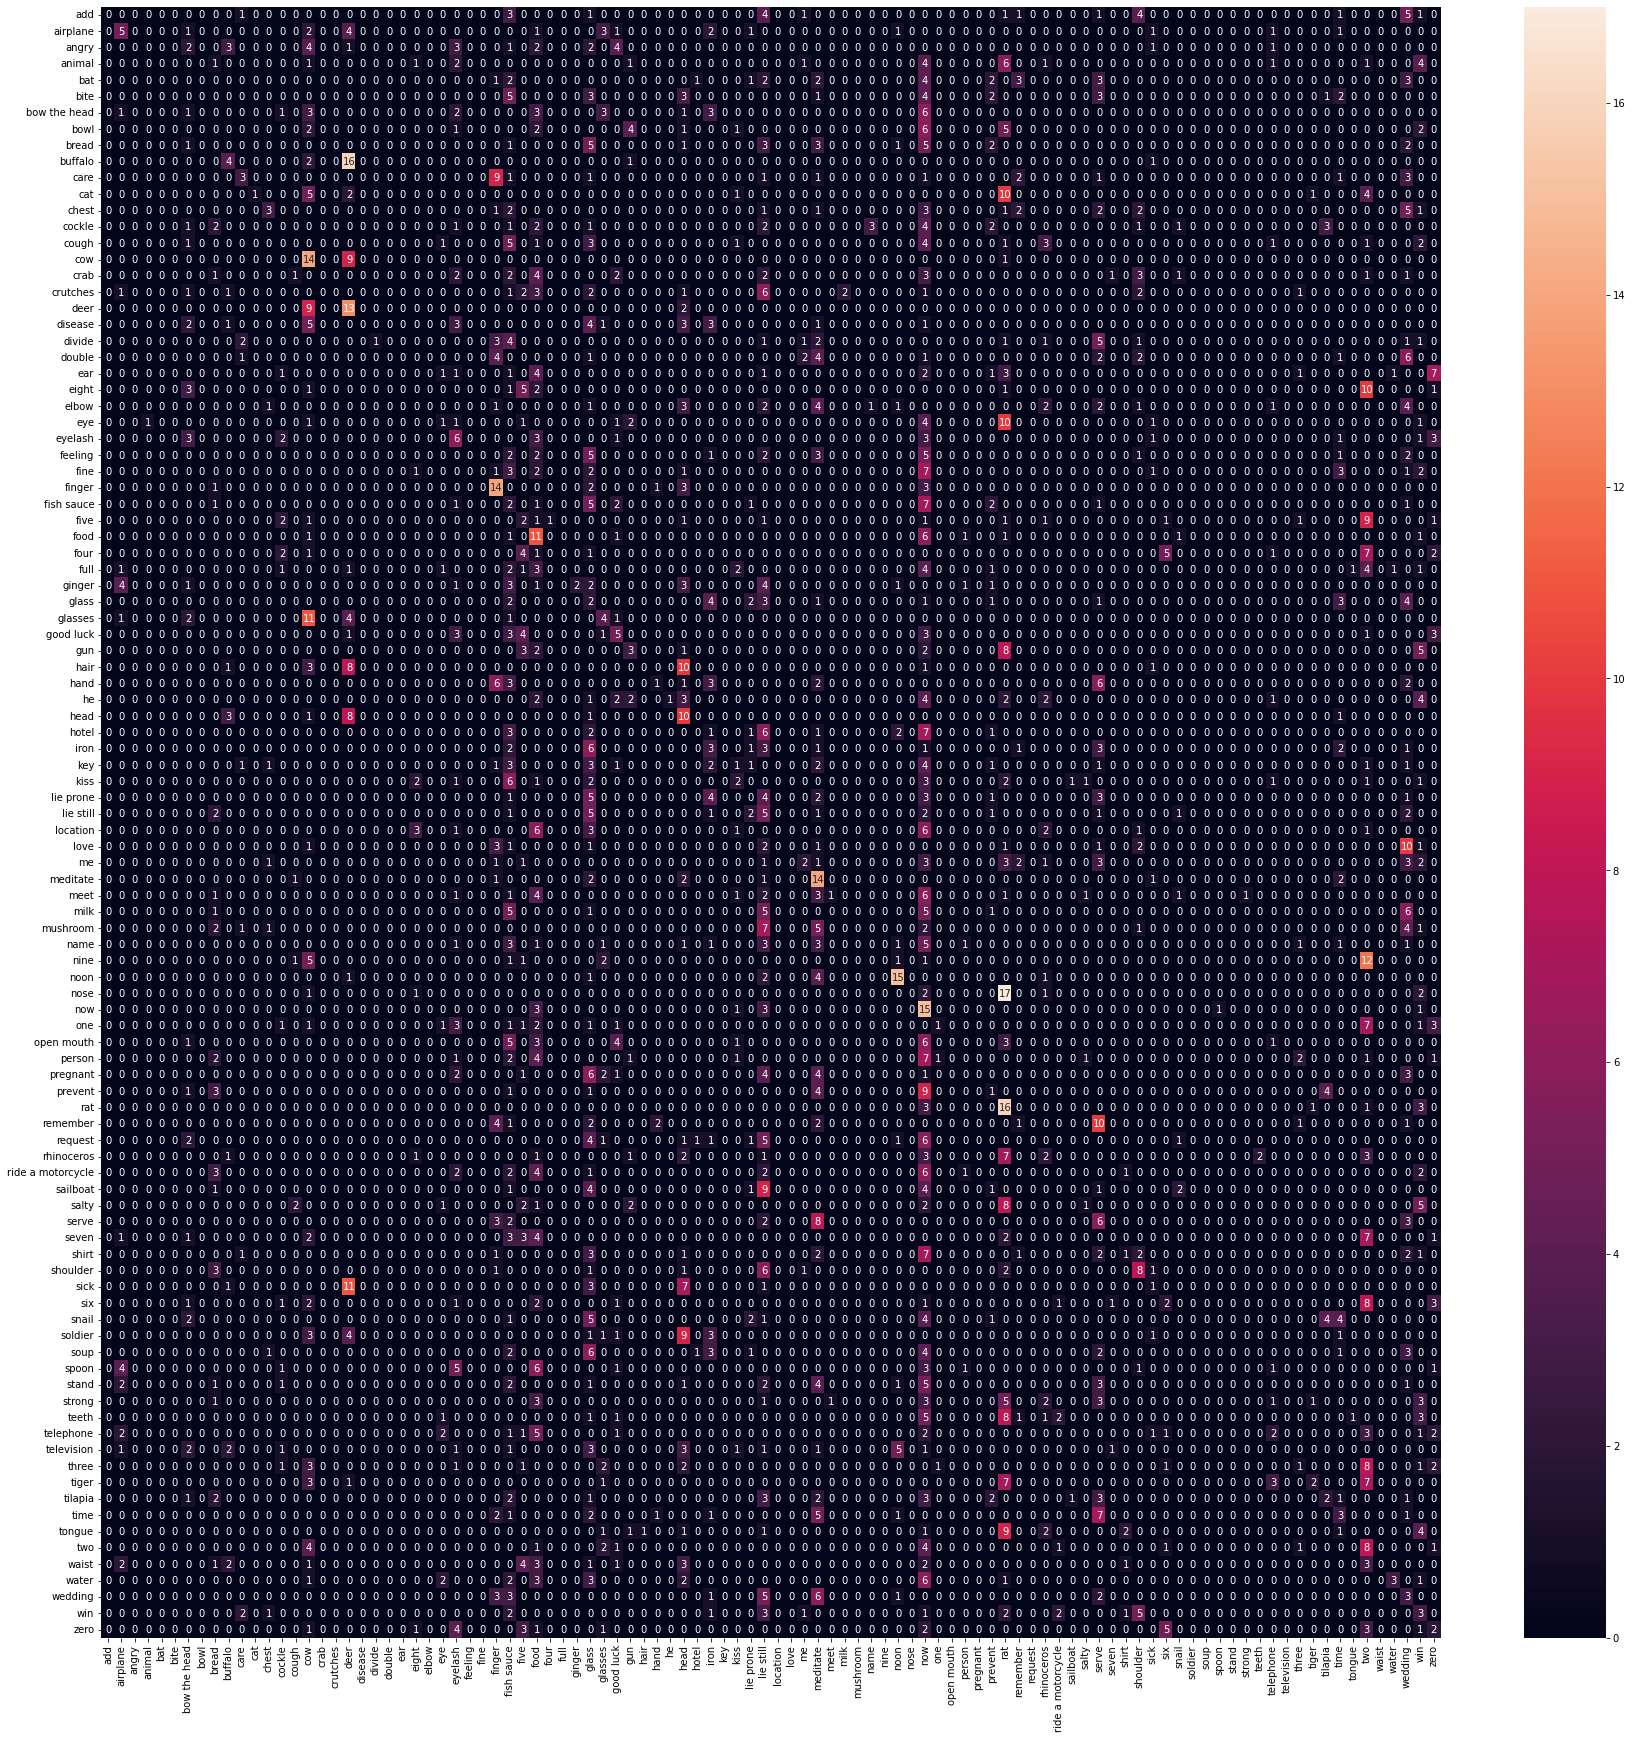

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = confusion_matrix(test_generator.classes,y_pred)
df_cm = pd.DataFrame(array, index = [i for i in target_names ],
                    columns = [i for i in target_names ])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

##Recap graph MobileNetV3Small

In [ ]:
# loading old history 
from pickle import load
import matplotlib.pyplot as plt

Path_Adam = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/Adam/history.csv'
with open(Path_Adam, 'rb') as handle:
    his_Adam = load(handle)

Path_rmsProp = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/rmsProp/history.csv'
with open(Path_rmsProp , 'rb') as handle:
    his_rmsProp = load(handle)

Path_SGD = '/content/drive/MyDrive/All Dataset/Github/Find_Parameters/MobileNetV3Small/SGD/history.csv'
with open(Path_SGD, 'rb') as handle:
    his_SGD = load(handle)



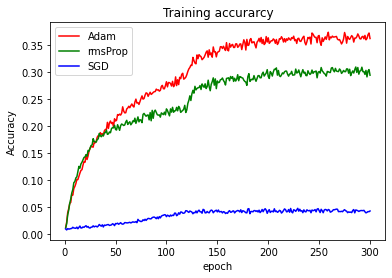

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Accuracy
acc1 = his_Adam['accuracy']
acc2 = his_rmsProp['accuracy']
acc3 = his_SGD['accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training accurarcy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()


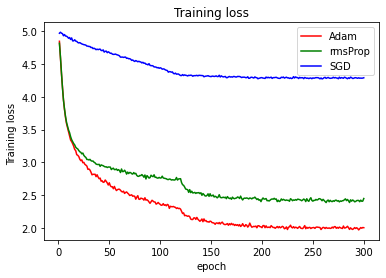

<Figure size 432x288 with 0 Axes>

In [ ]:
#Training Loss
acc1 = his_Adam['loss']
acc2 = his_rmsProp['loss']
acc3 = his_SGD['loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Training loss')
plt.ylabel('Training loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

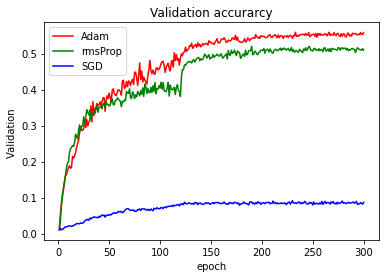

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Accuracy
acc1 = his_Adam['val_accuracy']
acc2 = his_rmsProp['val_accuracy']
acc3 = his_SGD['val_accuracy']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation accurarcy')
plt.ylabel('Validation ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()

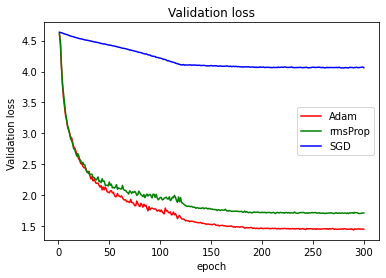

<Figure size 432x288 with 0 Axes>

In [ ]:
#Validation Loss
acc1 = his_Adam['val_loss']
acc2 = his_rmsProp['val_loss']
acc3 = his_SGD['val_loss']
epochs1 = range(1, len(acc1)+1)
epochs2 = range(1, len(acc2)+1)
epochs3 = range(1, len(acc3)+1)
plt.plot(epochs1, acc1, 'r', label='Adam')
plt.plot(epochs2, acc2, 'g', label='rmsProp')
plt.plot(epochs3, acc3, 'b', label='SGD')
plt.title('Validation loss')
plt.ylabel('Validation loss ')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.show()